<a class="anchor" id="ToC"></a>
## Table of Content
* [First Bullet Header](#First-bullet)
* [Convention](#Convention)
* [Data cleaning](#Datacleaning)
    * [`person_1`](#person_1)
    * [`static`](#static_0)
    * [`static_cb`](#static_cb)
    * [Data type conversion](#dtype)
 * [Preliminary training](#first_training)
 * [Exploratory data analysis](#eda)
    * [Categorical variables](#categorical)
        * [Mutual information (MI) analysis](#MI)
 * [Feature engineering](#feature_engine)
 * [Training](#training)
 * [Feature importance analysis](#shap)

## First Bullet Header <a class="anchor" id="first-bullet"></a>

drop columns with only one value (be careful with the categorical features)
form blocks of features with similar qualitative meanings

Data imbalance

## Convention <a class="anchor" id="Convention"></a>
* In treating date-related features, we either use `date_decision` or 2018-01 as a reference point, whichever more appropriate under the context.
* The first letter the name of derived features is capitalized.

## Choose table to work on:
`train_person_1`, `train_static_0_0+train_static_0_1`, `train_static_cb_0`

# Data cleaning<a class='anchor' id='Datacleaning'></a>

In [1]:
import shap

#import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#Path = '/content/drive/My Drive/data-science-project-loan-default-risk/Kaggle_files/csv_files/'
Path = 'data-science-project-loan-default-risk/Kaggle_files/csv_files/train/'

In [2]:
# Load base table
train_basetable = pd.read_csv(Path+'train_base.csv')
train_basetable

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


## Data cleaning for `person_1` <a class="anchor" id="person_1"></a>

In [3]:
person = pd.read_csv(Path+'train_person_1.csv')

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_16173/2900759076.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  person = pd.read_csv(Path+'train_person_1.csv')


In [5]:
person.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2973991 entries, 0 to 2973990
Data columns (total 37 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   case_id                    int64  
 1   birth_259D                 object 
 2   birthdate_87D              object 
 3   childnum_185L              float64
 4   contaddr_district_15M      object 
 5   contaddr_matchlist_1032L   object 
 6   contaddr_smempladdr_334L   object 
 7   contaddr_zipcode_807M      object 
 8   education_927M             object 
 9   empl_employedfrom_271D     object 
 10  empl_employedtotal_800L    object 
 11  empl_industry_691L         object 
 12  empladdr_district_926M     object 
 13  empladdr_zipcode_114M      object 
 14  familystate_447L           object 
 15  gender_992L                object 
 16  housetype_905L             object 
 17  housingtype_772L           object 
 18  incometype_1044T           object 
 19  isreference_387L           object 
 20  la

We will only extract information of the person themself.
Below, we record columns whose information can be obtained from looking at the rows with `num_group1` to 0.

(`isreference_387L` is not included since it concerns whether the person on that row is the reference contact, and is not information tied to the applicant themself.

For similar reasons, `personindex_1023L`, `persontype_1072L`, `persontype_792L`,`relationshiptoclient_415T`,`relationshiptoclient_642T`,`remitter_829L` are excluded. It is not to mean that they cannot be utilized to aggregate into useful features though.)

(`role_993L` is dropped because of high null ratio.)

There are columns with duplicate information:

`birth_259D` and `birthdate_87D`

`familystate_447L` and `maritalst_703L`

`gender_992L` and `sex_738L`

`housetype_905L` and `housingtype_772L`

After we look at the columns carefully, here is the collection of features we will extract from `train_person_1.csv`.

In [6]:
numgroup_0_columns = ['birth_259D','contaddr_district_15M',
                      'contaddr_matchlist_1032L','contaddr_smempladdr_334L',
                      'contaddr_zipcode_807M','education_927M',
                     'empl_employedfrom_271D','empl_employedtotal_800L',
                      'empl_industry_691L','empladdr_district_926M','empladdr_zipcode_114M',
                     'familystate_447L','sex_738L','housetype_905L','incometype_1044T',
                     'language1_981M','mainoccupationinc_384A','registaddr_district_1083M',
                     'registaddr_zipcode_184M','role_1084L','safeguarantyflag_411L','type_25L']
numgroup_1_columns =['childnum_185L']

We will later convert `birth_259D` and `empl_employedfrom_271D` into time relative to `date_decision`.

This facilitates later work in exploratory data analysis, feature engineering and modelling when we deal with date-related features.

In [7]:
person_to_int = ['childnum_185L']

In [8]:
person_date = ['birth_259D','empl_employedfrom_271D']

In [9]:
train_basetable = train_basetable.merge(person[person.num_group1 == 0][['case_id']+numgroup_0_columns], how='left',on='case_id')
train_basetable = train_basetable.merge(person[person.num_group1 == 1][['case_id']+numgroup_1_columns], how='left',on='case_id')

In [10]:
del person

In [11]:
# Should have a total of 28 columns
train_basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Data columns (total 28 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   case_id                    1526659 non-null  int64  
 1   date_decision              1526659 non-null  object 
 2   MONTH                      1526659 non-null  int64  
 3   WEEK_NUM                   1526659 non-null  int64  
 4   target                     1526659 non-null  int64  
 5   birth_259D                 1526659 non-null  object 
 6   contaddr_district_15M      1526659 non-null  object 
 7   contaddr_matchlist_1032L   1526218 non-null  object 
 8   contaddr_smempladdr_334L   1526218 non-null  object 
 9   contaddr_zipcode_807M      1526659 non-null  object 
 10  education_927M             1526659 non-null  object 
 11  empl_employedfrom_271D     566701 non-null   object 
 12  empl_employedtotal_800L    528315 non-null   object 
 13  empl_industr

## Data cleaning for `static_0_0`+`static_0_1`<a class='anchor' id='static_0'></a>

In [12]:
static_0 = pd.read_csv(Path + 'train_static_0_0.csv')
static_1 = pd.read_csv(Path + 'train_static_0_1.csv')
static = pd.concat([static_0,static_1])

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_16173/4137936555.py:1: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static_0 = pd.read_csv(Path + 'train_static_0_0.csv')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_16173/4137936555.py:2: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  static_1 = pd.read_csv(Path + 'train_static_0_1.csv')


Columns with overlaping information:

`currdebt_22A` and `currdebtcredtyperange_828A`

`eir_270L` and `interestrate_311L`

`isbidproduct_1095L` and `isbidproductrequest_292L` (the latter is mostly NaN and contain one contradictory value)

`lastapprcommoditycat_1041M` and `lastapprcommoditytypec_5251766M` (but their values look different) (now I see one is category and the other is type)

`lastrejectcommoditycat_161M` and `lastrejectcommodtypec_5251769M` (same as above; this is for the last rejected application)

`lastrejectreason_759M` and `lastrejectreasonclient_4145040M` (one is rejected application and one is rejected loan)

`mastercontrelectronic_519L` and `mastercontrexist_109L` (Some values do not agree but the proportion is low)

`mindbddpdlast24m_3658935P` and `mindbdtollast24m_4525191P` (similar description but slightly different values)

We will drop the duplicated columns.

In [13]:
duplicate_columns = ['currdebtcredtyperange_828A','eir_270L','isbidproductrequest_292L',
                    'mastercontrelectronic_519L']
static = static.drop(duplicate_columns,axis=1)

Columns with single values:

`deferredmnthsnum_166L`,`commnoinclast6m_3546845L`,`interestrategrace_34L`

We will remove these features from the table.

In [14]:
single_columns = ['deferredmnthsnum_166L','commnoinclast6m_3546845L','interestrategrace_34L']
static = static.drop(single_columns, axis=1)

In [15]:
static_to_int = ['applicationcnt_361L','applications30d_658L','applicationscnt_1086L',
                 'applicationscnt_464L','applicationscnt_629L','applicationscnt_867L',
                 'actualdpdtolerance_344P','applicationcnt_361L','clientscnt12m_3712952L',
                 'clientscnt3m_3712950L','clientscnt6m_3712949L','clientscnt6m_3712949L',
                 'clientscnt_100L','clientscnt_1022L','clientscnt_1071L','clientscnt_1130L',
                 'clientscnt_136L','clientscnt_157L','clientscnt_257L','clientscnt_304L',
                 'clientscnt_360L','clientscnt_493L','clientscnt_533L','clientscnt_887L',
                 'clientscnt_946L','cntincpaycont9m_3716944L','cntpmts24_3658933L',
                 'daysoverduetolerancedd_3976961L',
                  'daysoverduetolerancedd_3976961L','homephncnt_628L',
                 'lastdependentsnum_448L','maxdbddpdlast1m_3658939P',
                 'maxdbddpdtollast12m_3658940P','maxdbddpdtollast6m_4187119P',
                 'maxdpdfrom6mto36m_3546853P','maxdpdinstlnum_3546846P',
                 'maxdpdlast12m_727P','maxdpdlast24m_143P','maxdpdlast3m_392P',
                 'maxdpdlast6m_474P','maxdpdlast9m_1059P','maxdpdtolerance_374P',
                 'mindbddpdlast24m_3658935P','mindbdtollast24m_4525191P',
                 'mobilephncnt_593L','numactivecreds_622L','numactivecredschannel_414L',
                 'numactiverelcontr_750L','numincomingpmts_3546848L',
                 'numinstlallpaidearly3d_817L','numinstls_657L',
                 'numinstlsallpaid_934L','numinstlswithdpd10_728L','numinstlswithdpd5_4187116L',
                 'numinstmatpaidtearly2d_4499204L','numinstpaid_4499208L',
                 'numinstpaidearly3d_3546850L','numinstpaidearly3dest_4493216L',
                 'numinstpaidearly5d_1087L','numinstpaidearly5dest_4493211L',
                 'numinstpaidearly5dobd_4499205L','numinstpaidearly_338L',
                 'numinstpaidearlyest_4493214L','numinstpaidlastcontr_4325080L',
                 'numinstpaidlate1d_3546852L','numinstregularpaid_973L',
                'numinstregularpaidest_4493210L','numinsttopaygr_769L',
                'numinsttopaygrest_4493213L','numinstunpaidmax_3546851L',
                'numinstunpaidmaxest_4493212L','numnotactivated_1143L',
                'numpmtchanneldd_318L','numrejects9m_859L',
                 'pmtnum_254L','sellerplacecnt_915L','sellerplacescnt_216L',
                  'posfpd10lastmonth_333P','posfpd30lastmonth_3976960P',
                  'posfstqpd30lastmonth_3976962P']

In [16]:
static_date = static.columns[static.columns.str.endswith('D')].tolist()

In [17]:
train_basetable = train_basetable.merge(static,how='left', on='case_id')

In [18]:
del static

In [19]:
# Should have a total of 188 columns
train_basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 188 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(124), int64(4), object(59)
memory usage: 2.1+ GB


## Data cleaning for `static_cb`<a class='anchor' id='static_cb'></a>

In [20]:
static_cb = pd.read_csv(Path+'train_static_cb_0.csv')

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_16173/872531873.py:1: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  static_cb = pd.read_csv(Path+'train_static_cb_0.csv')


In [21]:
cb_duplicate_columns = ['birthdate_574D','dateofbirth_337D','dateofbirth_342D',
                    'education_1103M','maritalst_385M','maritalst_893M']

In [22]:
static_cb = static_cb.drop(cb_duplicate_columns, axis=1)

In [23]:
cb_to_int = ['days120_123L','days180_256L','days30_165L','days360_512L','days90_310L',
         'firstquarter_103L','for3years_128L','for3years_504L','for3years_584L','formonth_118L',
         'formonth_206L','formonth_535L','forquarter_1017L','forquarter_462L','forquarter_634L',
         'fortoday_1092L','forweek_1077L','forweek_528L',
          'forweek_601L','foryear_618L','foryear_818L','foryear_850L',
          'fourthquarter_440L','numberofqueries_373L','pmtcount_4527229L','pmtcount_4955617L',
         'pmtcount_693L','pmtscount_423L','secondquarter_766L','thirdquarter_1082L']

In [24]:
cb_date = static_cb.columns[static_cb.columns.str.endswith('D')].tolist()

In [25]:
train_basetable = train_basetable.merge(static_cb,how='left',on='case_id')

In [26]:
del static_cb

In [27]:
# Should have a total of 234 columns
train_basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 234 entries, case_id to thirdquarter_1082L
dtypes: bool(1), float64(160), int64(4), object(69)
memory usage: 2.7+ GB


## Data type conversion<a class='anchor' id='dtype'></a>

First, we convert date features into integers so as to handle them as numerical variables.

For some features, which are supposedly to be integers by their definitions, they are stored as floats. We convert the data types of these features into Int32, as they might be imputed in a different way than other float-type variables.

After that, we convert the remaining features with dtype object into category. Here, we treat boolean features as category. The only feature with dtype bool is `isbidproduct_1095L`. All other boolean features were stored as objects, so we don't need additional treatment for those. `mastercontrexist_109L` was stored as float. It will be categorified as well.

`riskassesment_302T` is to be converted into a numerical feature.

Define functions that convert date features into integer type.

In [28]:
def year_relative_date_decision(df,column):
    return df.date_decision.str[0:4].astype('Int32')-df[column].str[0:4].astype('Int32')+(df.date_decision.str[5:7].astype('Int32')-df[column].str[5:7].astype('Int32'))/12
def year_relative_jan_18(df,column):
    return df[column].str[0:4].astype('Int32')-2018+(df[column].str[5:7].astype('Int32')-1)/12

In [29]:
for i in person_date:
    train_basetable['rel_apply_'+i] = year_relative_date_decision(train_basetable,i)
for i in static_date:
    train_basetable['rel_apply_'+i] = year_relative_date_decision(train_basetable,i)
for i in cb_date:
    train_basetable['rel_'+i] = year_relative_jan_18(train_basetable,i)

In [30]:
train_basetable = train_basetable.drop(person_date+static_date+cb_date,axis=1)

Now, we collect integral features to be converted.

In [31]:
columns_to_int = cb_to_int+person_to_int+static_to_int

In [32]:
for i in columns_to_int:
    train_basetable[i] = train_basetable[i].astype('Int32')

In [33]:
bool_to_cat = ['contaddr_matchlist_1032L','contaddr_smempladdr_334L',
               'safeguarantyflag_411L','isbidproduct_1095L',
              'equalitydataagreement_891L','equalityempfrom_62L','isdebitcard_729L',
               'opencred_647L','mastercontrexist_109L']

In [182]:
#for i in bool_to_cat:
#    train_basetable[i] = train_basetable[i].fillna('na')

In [183]:
#for i in bool_to_cat:
#    train_basetable[i] = train_basetable[i].astype('category')

Finally, we convert `riskassesment_302T` into a numerical feature.

In [34]:
# Define function that extracts percentage
def get_prob(s):
    if pd.isna(s):
        return np.nan
    else:
        perc_1st = s.find('%')
        hyphen_blank = s.find(' - ')
        prob_1st = int(s[0: perc_1st])
        prob_2nd = int(s[hyphen_blank+3: len(s)-1])

        return 0.5*(prob_1st+prob_2nd)

In [35]:
# Get the mean probability of default assesment from cb
train_basetable['cb_risk_mean'] = train_basetable['riskassesment_302T'].apply(get_prob)

In [36]:
train_basetable = train_basetable.drop(['riskassesment_302T'],axis=1)

We will treat null values in categorical variables as a label itself, so we are going to apply fillna.

In [44]:
# Create lists of columns of base and by types
columns_base = ['case_id','date_decision','MONTH','WEEK_NUM','target']
columns_float = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['float64','float32']).columns.tolist()
columns_int = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['Int32','Int64']).columns.tolist()

In [51]:
columns_object= train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','bool']).columns.tolist()
for i in columns_object:
    train_basetable[i] = train_basetable[i].fillna('na')
    #train_basetable[i] = train_basetable[i].astype('category')

In [61]:
columns_object= train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','bool']).columns.tolist()

#### Another test training (with categorical features)

In [146]:
cols_to_encode = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','bool']).columns.tolist()

In [147]:
for col in cols_to_encode:
    # Factorize assigns unique integer codes for each unique value in the column
    codes, uniques = pd.factorize(train_basetable[col], sort=True)
    # Map codes to the sequence 0.5, 1.5, 2.5, ...
    train_basetable[col] = codes * 1.0 + 0.5

In [148]:
for col in cols_to_encode:
    train_basetable[col] = train_basetable[col].fillna(0)

In [149]:
# Package we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [150]:
# Select numerical columns
columns_base = ['case_id','date_decision','MONTH','WEEK_NUM','target']
columns_float = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['float64','float32']).columns.tolist()
columns_int = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['Int32','Int64']).columns.tolist()
columns_object= train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','category']).columns.tolist()

In [152]:
train_basetable = train_basetable.drop(columns_object,axis=1)

In [153]:
# Train, validation, test split
data_train, data_test = train_test_split(train_basetable.copy(),
                                            shuffle=True,
                                            random_state=338,
                                            train_size = 0.6,
                                            stratify=train_basetable['target'])

data_valid, data_test = train_test_split(data_test.copy(),
                                            shuffle=True,
                                            random_state=338,
                                            train_size = 0.5,
                                            stratify=data_test['target'])

In [154]:
data_valid[columns_float]=data_valid[columns_float].fillna(data_train[columns_float].mean())
data_test[columns_float]=data_test[columns_float].fillna(data_train[columns_float].mean())
data_train[columns_float]=data_train[columns_float].fillna(data_train[columns_float].mean())

In [155]:
data_train[columns_int]=data_train[columns_int].fillna(0)
data_valid[columns_int]=data_valid[columns_int].fillna(0)
data_test[columns_int]=data_test[columns_int].fillna(0)

In [156]:
X_train = data_train.drop(columns = columns_base)
y_train = data_train.target

X_valid = data_valid.drop(columns = columns_base)
y_valid = data_valid.target

X_test = data_test.drop(columns = columns_base)
y_test = data_test.target

In [157]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[columns_float] = scaler.fit_transform(X_train[columns_float])
X_valid[columns_float] = scaler.fit_transform(X_valid[columns_float])
X_test[columns_float] = scaler.fit_transform(X_test[columns_float])

In [158]:
# Define the neural network architecture
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Specify the learning rate of the Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with AUC as the metric
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Check unique values in y_train
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Define class weights to address class imbalance
class_weights = {0: 30, 1: 1}  # Adjust weights based on the class distribution

# Check if the class weights match the unique classes
if not all(key in unique_classes for key in class_weights.keys()):
    raise ValueError(f"Class weights keys {class_weights.keys()} do not match the unique classes {unique_classes} in y_train")

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping], class_weight=class_weights)

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Test AUC: {auc_score:.4f}')

/Users/kwongszehong/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Unique classes in y_train: [0 1]
Epoch 1/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 15s 510us/step - auc: 0.5195 - loss: 4.0795 - val_auc: 0.5324 - val_loss: 3.4875
Epoch 2/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 15s 528us/step - auc: 0.5330 - loss: 4.2917 - val_auc: 0.5426 - val_loss: 7.1366
Epoch 3/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 496us/step - auc: 0.5457 - loss: 3.4751 - val_auc: 0.5645 - val_loss: 2.4898
Epoch 4/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 492us/step - auc: 0.5504 - loss: 2.3223 - val_auc: 0.5450 - val_loss: 3.0932
Epoch 5/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 504us/step - auc: 0.5500 - loss: 2.3551 - val_auc: 0.5482 - val_loss: 4.6741
Epoch 6/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 492us/step - auc: 0.5566 - loss: 2.1915 - val_auc: 0.5615 - val_loss: 1.1238
Epoch 7/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 497us/step - auc: 0.5649 - loss: 1.8636 - val_auc: 0.5625 - val_loss: 1.5857
Epoch 8/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 500us/step - auc: 0.5615 - loss: 1.1

Epoch 102/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 497us/step - auc: 0.6133 - loss: 0.2350 - val_auc: 0.6078 - val_loss: 0.2189
Epoch 103/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 490us/step - auc: 0.6061 - loss: 0.2290 - val_auc: 0.6340 - val_loss: 0.2138
Epoch 104/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 489us/step - auc: 0.6153 - loss: 0.2343 - val_auc: 0.6047 - val_loss: 0.2092
9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 242us/step
Test AUC: 0.7933


In [159]:
y_train_pred = model.predict(X_train)
roc_auc_score(y_train, y_train_pred)

28625/28625 ━━━━━━━━━━━━━━━━━━━━ 7s 250us/step


0.8059058531935976

In [160]:
y_valid_pred = model.predict(X_valid)
roc_auc_score(y_valid, y_valid_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 252us/step


0.7956602526228223

In [161]:
y_test_pred = model.predict(X_test)
roc_auc_score(y_test, y_test_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 239us/step


0.7932575373560832

## Preliminary training <a class="anchor" id="first_training"></a>

Using the cleaned data, we train a simple model to see how it goes.

In [103]:
# Package we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap

In [98]:
# Select numerical columns
columns_base = ['case_id','date_decision','MONTH','WEEK_NUM','target']
columns_float = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['float64','float32']).columns.tolist()
columns_int = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['Int32','Int64']).columns.tolist()
columns_object= train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','category']).columns.tolist()

Now, we do a train-test split.

In [101]:
train_basetable = train_basetable.drop(columns_object,axis=1)

In [104]:
# Train, validation, test split
data_train, data_test = train_test_split(train_basetable.copy(),
                                            shuffle=True,
                                            random_state=338,
                                            train_size = 0.6,
                                            stratify=train_basetable['target'])

data_valid, data_test = train_test_split(data_test.copy(),
                                            shuffle=True,
                                            random_state=338,
                                            train_size = 0.5,
                                            stratify=data_test['target'])

In [166]:
float_mean = data_train.drop(columns_base,axis=1)[columns_float].mean().to_dict()

To start model training, we first imput our data. We impute float columns by mean and integer columns by zeros. Note: the order of computing the following code is important: run the one for data_train at last!

In [105]:
data_valid[columns_float]=data_valid[columns_float].fillna(data_train[columns_float].mean())

In [106]:
data_test[columns_float]=data_test[columns_float].fillna(data_train[columns_float].mean())

In [107]:
data_train[columns_float]=data_train[columns_float].fillna(data_train[columns_float].mean())

In [108]:
data_train[columns_int]=data_train[columns_int].fillna(0)
data_valid[columns_int]=data_valid[columns_int].fillna(0)
data_test[columns_int]=data_test[columns_int].fillna(0)

In [109]:
X_train = data_train.drop(columns = columns_base)
y_train = data_train.target

X_valid = data_valid.drop(columns = columns_base)
y_valid = data_valid.target

X_test = data_test.drop(columns = columns_base)
y_test = data_test.target

Now, we scale the data.

In [110]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[columns_float] = scaler.fit_transform(X_train[columns_float])
X_valid[columns_float] = scaler.fit_transform(X_valid[columns_float])
X_test[columns_float] = scaler.fit_transform(X_test[columns_float])

In [74]:
# *****Compare scaling int features with the first model.*****
X_train[columns_int] = scaler.fit_transform(X_train[columns_int])
X_valid[columns_int] = scaler.fit_transform(X_valid[columns_int])
X_test[columns_int] = scaler.fit_transform(X_test[columns_int])

In [115]:
# Define the neural network architecture
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Specify the learning rate of the Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with AUC as the metric
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Check unique values in y_train
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Define class weights to address class imbalance
class_weights = {0: 30, 1: 1}  # Adjust weights based on the class distribution

# Check if the class weights match the unique classes
if not all(key in unique_classes for key in class_weights.keys()):
    raise ValueError(f"Class weights keys {class_weights.keys()} do not match the unique classes {unique_classes} in y_train")

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping], class_weight=class_weights)

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Test AUC: {auc_score:.4f}')

/Users/kwongszehong/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Unique classes in y_train: [0 1]
Epoch 1/300
 9465/28625 ━━━━━━━━━━━━━━━━━━━━ 8s 446us/step - auc_1: 0.5115 - loss: 2.2455

KeyboardInterrupt: 

For the test run without scaling integer columns, we calculate the AUC scores.

In [116]:
y_train_pred = model.predict(X_train)
roc_auc_score(y_train, y_train_pred)

28625/28625 ━━━━━━━━━━━━━━━━━━━━ 7s 236us/step


0.46096715539804084

In [113]:
y_valid_pred = model.predict(X_valid)
roc_auc_score(y_valid, y_valid_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 238us/step


0.7850883662507708

In [114]:
y_test_pred = model.predict(X_test)
roc_auc_score(y_test, y_test_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 236us/step


0.7852669026117978

In [124]:
# *****Compare scaling int features with the first model.*****
# Define the neural network architecture
model_int = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Specify the learning rate of the Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with AUC as the metric
model_int.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Check unique values in y_train
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Define class weights to address class imbalance
class_weights = {0: 30, 1: 1}  # Adjust weights based on the class distribution

# Check if the class weights match the unique classes
if not all(key in unique_classes for key in class_weights.keys()):
    raise ValueError(f"Class weights keys {class_weights.keys()} do not match the unique classes {unique_classes} in y_train")

# Train the model
history = model_int.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping], class_weight=class_weights)

# Predict probabilities for the test set
y_pred_proba = model_int.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Test AUC: {auc_score:.4f}')

/Users/kwongszehong/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Unique classes in y_train: [0 1]
Epoch 1/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 471us/step - auc_1: 0.5638 - loss: 0.3942 - val_auc_1: 0.5594 - val_loss: 0.2079
Epoch 2/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 463us/step - auc_1: 0.5920 - loss: 0.2389 - val_auc_1: 0.5871 - val_loss: 0.1970
Epoch 3/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 459us/step - auc_1: 0.5899 - loss: 0.2334 - val_auc_1: 0.5766 - val_loss: 0.1996
Epoch 4/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 452us/step - auc_1: 0.5966 - loss: 0.2275 - val_auc_1: 0.6053 - val_loss: 0.1929
Epoch 5/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 456us/step - auc_1: 0.5972 - loss: 0.2351 - val_auc_1: 0.5659 - val_loss: 0.2081
Epoch 6/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 456us/step - auc_1: 0.5977 - loss: 0.2315 - val_auc_1: 0.5842 - val_loss: 0.1997
Epoch 7/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 458us/step - auc_1: 0.5994 - loss: 0.2330 - val_auc_1: 0.5869 - val_loss: 0.2012
Epoch 8/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 457us/st

In [271]:
# *** Check the performance of model without any scaling ***
# Define the neural network architecture
model3 = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Specify the learning rate of the Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with AUC as the metric
model3.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Check unique values in y_train
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Define class weights to address class imbalance
class_weights = {0: 30, 1: 1}  # Adjust weights based on the class distribution

# Check if the class weights match the unique classes
if not all(key in unique_classes for key in class_weights.keys()):
    raise ValueError(f"Class weights keys {class_weights.keys()} do not match the unique classes {unique_classes} in y_train")

# Train the model
history = model3.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping], class_weight=class_weights)

# Predict probabilities for the test set
y_pred3_proba = model3.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred3_proba)

print(f'Test AUC: {auc_score:.4f}')

/Users/kwongszehong/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Unique classes in y_train: [0 1]
Epoch 1/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 15s 503us/step - auc_2: 0.5589 - loss: 0.5088 - val_auc_2: 0.6000 - val_loss: 0.1972
Epoch 2/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 461us/step - auc_2: 0.5864 - loss: 0.2416 - val_auc_2: 0.5824 - val_loss: 0.2002
Epoch 3/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 461us/step - auc_2: 0.5895 - loss: 0.2289 - val_auc_2: 0.5879 - val_loss: 0.2006
Epoch 4/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 462us/step - auc_2: 0.5938 - loss: 0.2270 - val_auc_2: 0.5745 - val_loss: 0.2078
Epoch 5/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 15s 522us/step - auc_2: 0.5965 - loss: 0.2275 - val_auc_2: 0.5957 - val_loss: 0.1991
Epoch 6/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 13s 470us/step - auc_2: 0.5999 - loss: 0.2277 - val_auc_2: 0.6194 - val_loss: 0.1858
Epoch 7/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 14s 486us/step - auc_2: 0.6006 - loss: 0.2303 - val_auc_2: 0.5769 - val_loss: 0.2015
Epoch 8/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 15s 513us/st

In [146]:
y_train_pred = model.predict(X_train)
roc_auc_score(y_train, y_train_pred)

28625/28625 ━━━━━━━━━━━━━━━━━━━━ 7s 241us/step


0.787358959729145

In [125]:
# *****Compare scaling int features with the first model.*****
y_train_pred = model_int.predict(X_train)
roc_auc_score(y_train, y_train_pred)

28625/28625 ━━━━━━━━━━━━━━━━━━━━ 7s 231us/step


0.8052498913478691

In [272]:
# *****Compare no scaling with the first model.*****
y_train_pred = model3.predict(X_train)
roc_auc_score(y_train, y_train_pred)

28625/28625 ━━━━━━━━━━━━━━━━━━━━ 7s 236us/step


0.826448922419748

In [147]:
y_valid_pred = model.predict(X_valid)
roc_auc_score(y_valid, y_valid_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 238us/step


0.7792532891482632

In [126]:
# *****Compare scaling int features with the first model.*****
y_valid_pred = model_int.predict(X_valid)
roc_auc_score(y_valid, y_valid_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 231us/step


0.7649396129301848

In [273]:
# *****Compare no scaling with the first model.*****
y_valid_pred = model3.predict(X_valid)
roc_auc_score(y_valid, y_valid_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 232us/step


0.779725990943999

In [148]:
y_test_pred = model.predict(X_test)
roc_auc_score(y_test, y_test_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 240us/step


0.7803036549370496

In [304]:
# *****Compare scaling int features with the first model.*****
y_test_pred = model_int.predict(X_test)
roc_auc_score(y_test, y_test_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 229us/step


0.7654259684897143

In [274]:
# *****Compare no scaling with the first model.*****
y_test_pred = model3.predict(X_test)
roc_auc_score(y_test, y_test_pred)

9542/9542 ━━━━━━━━━━━━━━━━━━━━ 2s 228us/step


0.7800897564215921

In [88]:
# save model
model.save('first_run.keras') # Load: nn_num_model = tf.keras.models.load_model('saved_model/nn_numeric_model')

In [81]:
y_test_pred_series = pd.Series(y_test_pred.reshape(-1))
y_test_pred_series.describe()

count    305332.000000
mean          0.001037
std           0.002545
min           0.000000
25%           0.000170
50%           0.000516
75%           0.001332
max           0.996383
dtype: float64

In [305]:
# *****Compare scaling int features with the first model.*****
y_test_pred_series = pd.Series(y_test_pred.reshape(-1))
y_test_pred_series.describe()

count    305332.000000
mean          0.001121
std           0.002027
min           0.000000
25%           0.000086
50%           0.000398
75%           0.001251
max           0.089184
dtype: float64

In [275]:
# *****Compare no scaling with the first model.*****
y_test_pred_series = pd.Series(y_test_pred.reshape(-1))
y_test_pred_series.describe()

count    305332.000000
mean          0.001137
std           0.003393
min           0.000000
25%           0.000122
50%           0.000405
75%           0.001100
max           0.439966
dtype: float64

In [114]:
y_test_pred_series.quantile(.99)

0.0053100259974598885

In [118]:
len(y_test_pred_series[y_test_pred_series>=0.005])

16448

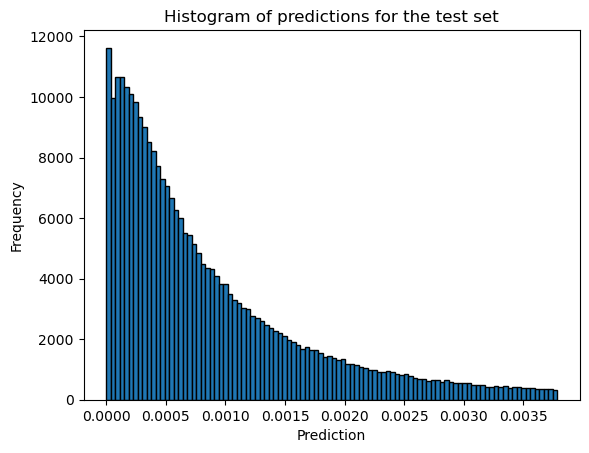

In [150]:
import numpy as np
import matplotlib.pyplot as plt

cutoff = y_test_pred_series.quantile(.95)
# Generate a NumPy array of random values between 0 and 1
data = y_test_pred.reshape(-1)

# Define the bin width
bin_width = cutoff/100

# Calculate the number of bins
bins = np.arange(0, cutoff + bin_width, bin_width)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black')

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions for the test set')

# Show the plot
plt.show()

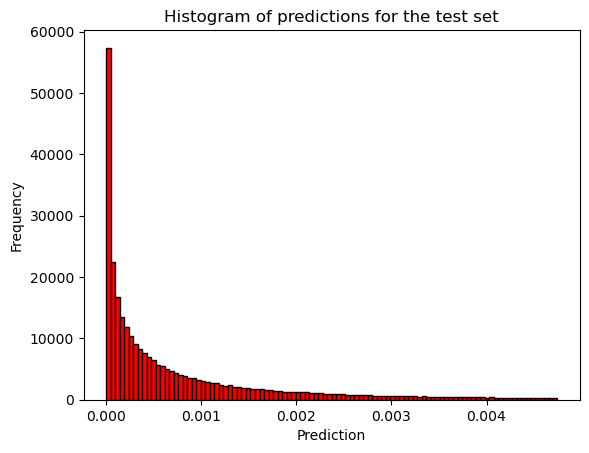

In [306]:
# *****Compare scaling int features with the first model.*****
import numpy as np
import matplotlib.pyplot as plt

cutoff = y_test_pred_series.quantile(.95)
# Generate a NumPy array of random values between 0 and 1
data = y_test_pred.reshape(-1)

# Define the bin width
bin_width = cutoff/100

# Calculate the number of bins
bins = np.arange(0, cutoff + bin_width, bin_width)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black',color='red')

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions for the test set')

# Show the plot
plt.show()

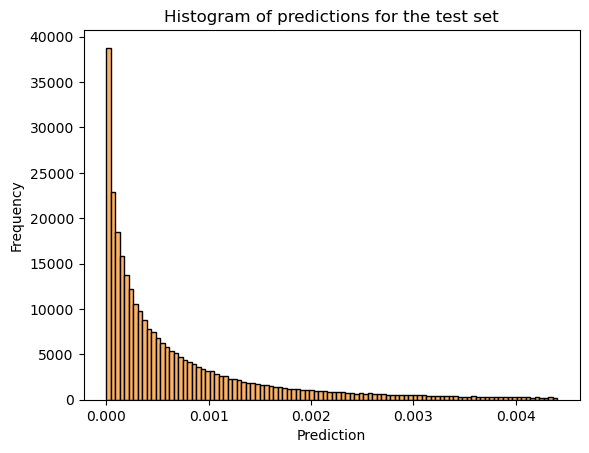

In [303]:
# *****Compare no scaling with the first model.*****
import numpy as np
import matplotlib.pyplot as plt

cutoff = y_test_pred_series.quantile(.95)
# Generate a NumPy array of random values between 0 and 1
data = y_test_pred.reshape(-1)

# Define the bin width
bin_width = cutoff/100

# Calculate the number of bins
bins = np.arange(0, cutoff + bin_width, bin_width)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black',color='#FAB267')

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions for the test set')

# Show the plot
plt.show()

In [151]:
y_train_pred_series = pd.Series(y_train_pred.reshape(-1))
y_train_pred_series.describe()

count    915995.000000
mean          0.001207
std           0.005340
min           0.000000
25%           0.000276
50%           0.000663
75%           0.001468
max           1.000000
dtype: float64

In [278]:
# *****Compare no scaling with the first model.*****
y_train_pred_series = pd.Series(y_train_pred.reshape(-1))
y_train_pred_series.describe()

count    915995.000000
mean          0.001118
std           0.003767
min           0.000000
25%           0.000122
50%           0.000402
75%           0.001085
max           0.793786
dtype: float64

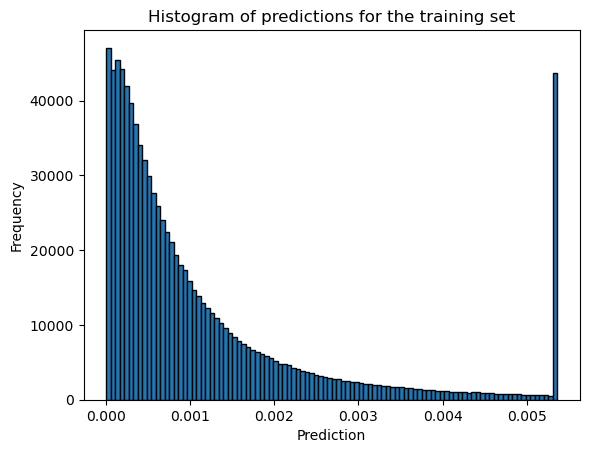

In [152]:
import numpy as np
import matplotlib.pyplot as plt

cutoff = y_train_pred_series.quantile(.99)
# Generate a NumPy array of random values between 0 and 1
data = y_train_pred.reshape(-1)

# Define the bin width
bin_width = cutoff/100

# Calculate the number of bins
bins = np.arange(0, cutoff + bin_width, bin_width)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black')

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions for the training set')

# Show the plot
plt.show()

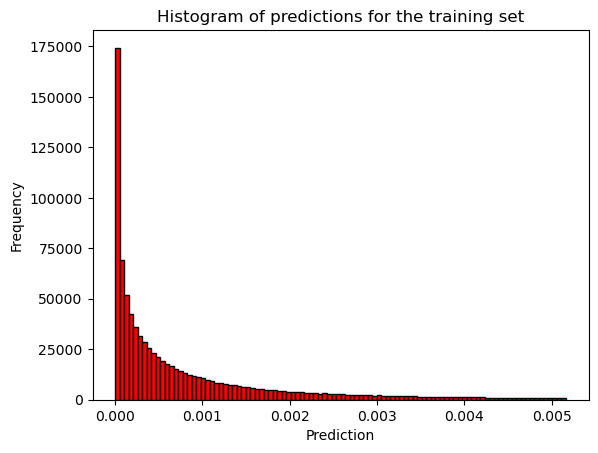

In [130]:
# *****Compare scaling int features with the first model.*****
import numpy as np
import matplotlib.pyplot as plt

cutoff = y_train_pred_series.quantile(.95)
# Generate a NumPy array of random values between 0 and 1
data = y_train_pred.reshape(-1)

# Define the bin width
bin_width = cutoff/100

# Calculate the number of bins
bins = np.arange(0, cutoff + bin_width, bin_width)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black',color='red')

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions for the training set')

# Show the plot
plt.show()

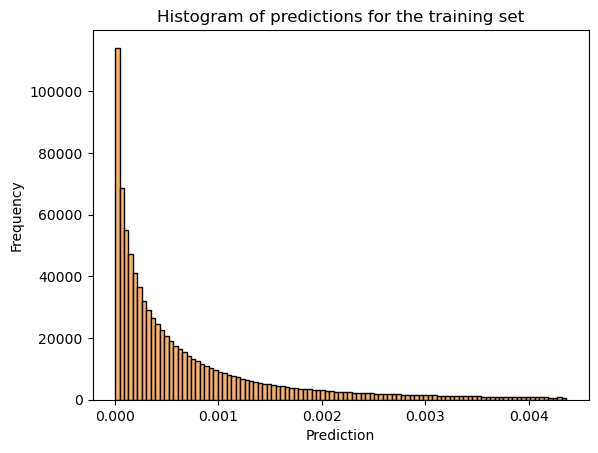

In [307]:
# *****Compare no scaling with the first model.*****
import numpy as np
import matplotlib.pyplot as plt

cutoff = y_train_pred_series.quantile(.95)
# Generate a NumPy array of random values between 0 and 1
data = y_train_pred.reshape(-1)

# Define the bin width
bin_width = cutoff/100

# Calculate the number of bins
bins = np.arange(0, cutoff + bin_width, bin_width)

# Plot the histogram
plt.hist(data, bins=bins, edgecolor='black',color='#FAB267')

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.title('Histogram of predictions for the training set')

# Show the plot
plt.show()

In [99]:
y_train_pred

array([[0.00142776],
       [0.00308572],
       [0.00168627],
       ...,
       [0.00018332],
       [0.00075455],
       [0.00095739]], dtype=float32)

In [281]:
y_train_pred

array([[4.5798667e-04],
       [9.3376439e-04],
       [1.0237304e-03],
       ...,
       [6.9515743e-05],
       [4.3884135e-04],
       [1.8196016e-04]], dtype=float32)

In [98]:
y_valid_pred_series = pd.Series(y_valid_pred.reshape(-1))
y_valid_pred_series.describe()

count    305332.000000
mean          0.001587
std           0.004150
min           0.000000
25%           0.000505
50%           0.001108
75%           0.002138
max           1.000000
dtype: float64

## Exploratory data analysis <a class="anchor" id="eda"></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
columns_not_corr = ['case_id','date_decision','MONTH','WEEK_NUM']
# Select numerical columns
columns_base = ['case_id','date_decision','MONTH','WEEK_NUM','target']
columns_float = train_basetable.drop(columns_base,axis=1).select_dtypes(include = 'float64').columns.tolist()
columns_int = train_basetable.drop(columns_base,axis=1).select_dtypes(include = 'Int32').columns.tolist()
# Here, for convenience, we put boolean column into objects.
columns_object= train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','bool']).columns.tolist()

There's lots of columns there. We first arrange the correlation matrix in the order of correlation with the target.Although the target is binary, we can somewhat think of it as a probability so the correlation coefficients is still informative.

In [225]:
pre_correlation_matrix = train_basetable.drop(columns=columns_not_corr+columns_object).corr()
pre_correlation_matrix_abs = pre_correlation_matrix.abs()
columns_arrange = pre_correlation_matrix_abs.sort_values(by='target',ascending = False)['target'].index.tolist()
correlation_matrix = pre_correlation_matrix.reindex(columns_arrange,axis=0)
correlation_matrix = correlation_matrix.reindex(columns_arrange,axis=1)
correlation_matrix

,target,riskassesment_940T,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pctinstlsallpaidlat10d_839L,numinstlswithdpd10_728L,avgmaxdpdlast9m_3716943P,pctinstlsallpaidearl3d_427L,rel_apply_datelastinstal40dpd_247D,...,avgpmtlast12m_4525200A,applicationcnt_361L,maxinstallast24m_3658928A,maxpmtlast3m_4525190A,clientscnt_946L,clientscnt_304L,mastercontrexist_109L,formonth_118L,forquarter_462L,forweek_601L
target,1.000000,-0.180037,0.125055,0.122669,0.119374,0.114081,0.090439,0.089878,-0.087156,-0.086439,...,-0.001701,0.001367,-0.001042,0.000932,-0.000702,-0.000596,NaN,NaN,NaN,NaN
riskassesment_940T,-0.180037,1.000000,-0.290684,-0.278014,-0.268719,-0.252315,-0.222302,-0.157197,0.205669,0.165272,...,-0.043673,-0.002698,-0.037605,-0.011935,-0.006130,-0.015497,NaN,NaN,NaN,NaN
pctinstlsallpaidlate1d_3546856L,0.125055,-0.290684,1.000000,0.895843,0.848849,0.787654,0.432136,0.268483,-0.568188,0.168599,...,-0.016077,-0.000337,-0.050098,-0.037624,0.000665,-0.003211,NaN,NaN,NaN,NaN
pctinstlsallpaidlate4d_3546849L,0.122669,-0.278014,0.895843,1.000000,0.975204,0.927012,0.494103,0.293830,-0.440292,0.198693,...,-0.001152,-0.000160,-0.040126,-0.034008,-0.004155,-0.002793,NaN,NaN,NaN,NaN
pctinstlsallpaidlate6d_3546844L,0.119374,-0.268719,0.848849,0.975204,1.000000,0.965049,0.503289,0.291116,-0.407296,0.210797,...,0.005180,-0.000122,-0.035566,-0.031324,-0.005277,-0.002976,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clientscnt_304L,-0.000596,-0.015497,-0.003211,-0.002793,-0.002976,-0.003656,0.001198,-0.002205,0.007166,0.000664,...,0.008308,0.001146,0.016444,0.006670,-0.001776,1.000000,NaN,NaN,NaN,NaN
mastercontrexist_109L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
formonth_118L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
forquarter_462L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [226]:
high_corr_columns = correlation_matrix['target'].head(50).index.tolist()
high_corr_columns

['target',
 'riskassesment_940T',
 'pctinstlsallpaidlate1d_3546856L',
 'pctinstlsallpaidlate4d_3546849L',
 'pctinstlsallpaidlate6d_3546844L',
 'pctinstlsallpaidlat10d_839L',
 'numinstlswithdpd10_728L',
 'avgmaxdpdlast9m_3716943P',
 'pctinstlsallpaidearl3d_427L',
 'rel_apply_datelastinstal40dpd_247D',
 'forquarter_634L',
 'formonth_535L',
 'days120_123L',
 'numinstlswithdpd5_4187116L',
 'days180_256L',
 'days90_310L',
 'foryear_850L',
 'days360_512L',
 'numberofqueries_373L',
 'numrejects9m_859L',
 'days30_165L',
 'numinstpaidearly3dest_4493216L',
 'numinstmatpaidtearly2d_4499204L',
 'rel_apply_firstclxcampaign_1125D',
 'mobilephncnt_593L',
 'pmtaverage_4527227A',
 'avgdbdtollast24m_4525197P',
 'numinstpaidearly5dobd_4499205L',
 'numinstpaidearlyest_4493214L',
 'numinstpaidearly3d_3546850L',
 'for3years_504L',
 'numinstlallpaidearly3d_817L',
 'rel_apply_lastrejectdate_50D',
 'rel_apply_birth_259D',
 'rel_apply_empl_employedfrom_271D',
 'avgdbddpdlast24m_3658932P',
 'numinstlsallpaid_934

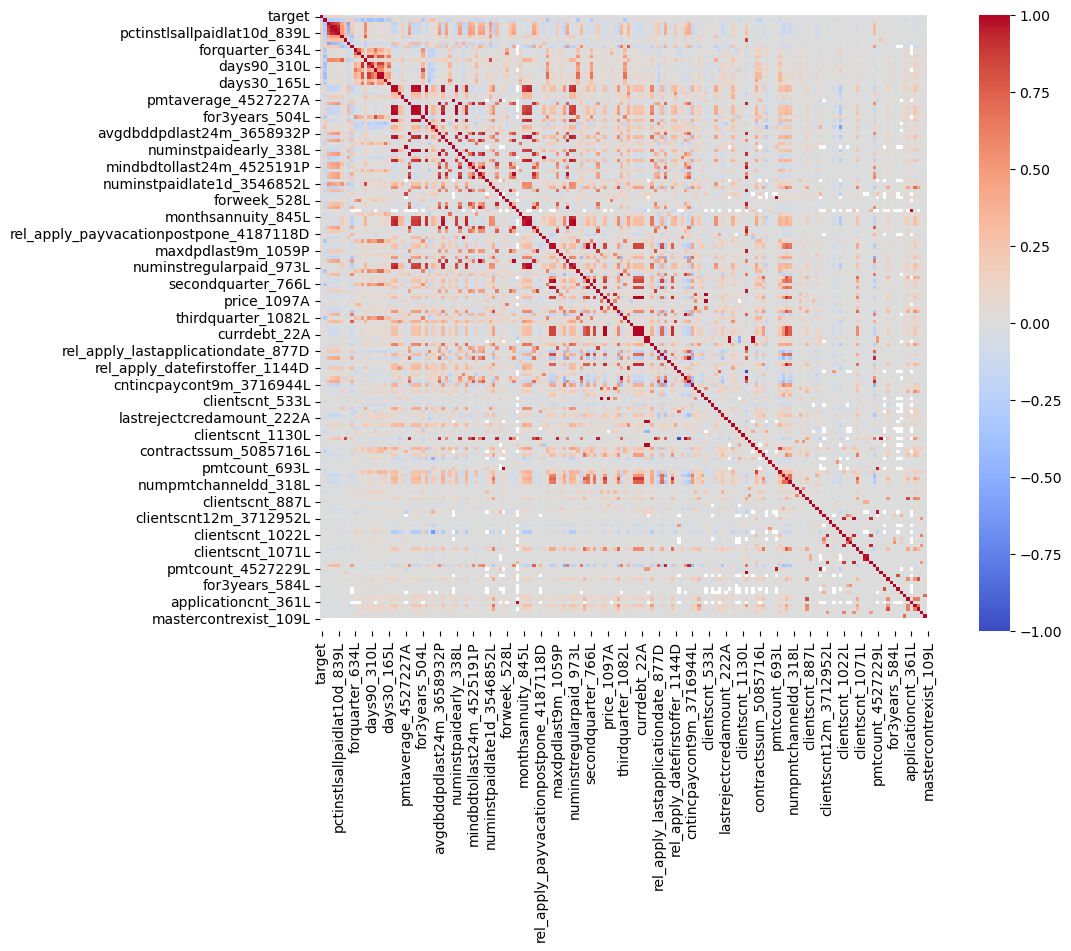

In [209]:
# Calculate the correlation matrix
#correlation_matrix = train_basetable.drop(columns=columns_not_corr+columns_object).corr()

# Create the heatmap
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix, cmap = 'coolwarm')
plt.show()

In [227]:
columns_annuity=correlation_matrix['target'].loc[correlation_matrix.index.str.contains('annu')].index.tolist()
columns_annuity

['monthsannuity_845L',
 'annuity_780A',
 'maxannuity_159A',
 'maxannuity_4075009A',
 'annuitynextmonth_57A']

### Categorical variables <a class="anchor" id="categorical"></a>
back to [ToC](#ToC)

#### Mutual information (MI) analysis<a class="anchor" id="MI"></a>
#### MI for features

In [198]:
def MI(col):
    df_col = train_basetable[['target',col]]
    p_0 = len(df_col[df_col.target ==0])/len(df_col)
    p_1 = len(df_col[df_col.target ==1])/len(df_col)
    h_x = -p_0*np.log(p_0)-p_1*np.log(p_1)
    l = len(df_col)
    label = df_col[col].value_counts().index.tolist()
    h_xy = 0
    for i in label:
        df = df_col[df_col[col] == i]
        count_0 = len(df[df['target']==0])
        count_1 = len(df[df['target']==1])
        if count_0 == 0:
            lnp_0y = 0
        else:
            lnp_0y = np.log(count_0/len(df))
        if count_1 == 0:
            lnp_1y = 0
        else:
            lnp_1y = np.log(count_1/len(df))
        h_xy += (count_0/l)*lnp_0y + (count_1/l)*lnp_1y
        
    return h_x - h_xy

In [202]:
for j in columns_object:
    print(f'MI for {j}: {MI(j)}')

MI for contaddr_district_15M: 0.2784462828589568
MI for contaddr_matchlist_1032L: 0.27940598878321443
MI for contaddr_smempladdr_334L: 0.27940593320353874
MI for contaddr_zipcode_807M: 0.27735623035052825
MI for education_927M: 0.2788503501372949
MI for empl_employedtotal_800L: 0.2789519329641425
MI for empl_industry_691L: 0.27894417689300777
MI for empladdr_district_926M: 0.2788456880567002
MI for empladdr_zipcode_114M: 0.2778717343960832
MI for familystate_447L: 0.27917056769555704
MI for sex_738L: 0.27874980268753735
MI for housetype_905L: 0.27927330453515387
MI for incometype_1044T: 0.27821756857178076
MI for language1_981M: 0.27915151275885547
MI for registaddr_district_1083M: 0.27835435683898535
MI for registaddr_zipcode_184M: 0.2772232764517256
MI for role_1084L: 0.2792696923239342
MI for safeguarantyflag_411L: 0.2794054628103244
MI for type_25L: 0.2793820206033272
MI for bankacctype_710L: 0.27939086990123485
MI for cardtype_51L: 0.2793998986451116
MI for credtype_322L: 0.279385

In [208]:
MI_col = []
for j in columns_object:
    MI_col.append(MI(j))

In [211]:
MI_df = pd.DataFrame({'feature': columns_object,
                    'MI': MI_col})

In [216]:
MI_df.sort_values(by = ['MI'],ascending = False)

,feature,MI
1,contaddr_matchlist_1032L,0.279406
2,contaddr_smempladdr_334L,0.279406
17,safeguarantyflag_411L,0.279405
27,isdebitcard_729L,0.279401
20,cardtype_51L,0.279400
26,isbidproduct_1095L,0.279396
19,bankacctype_710L,0.279391
21,credtype_322L,0.279386
18,type_25L,0.279382
38,paytype1st_925L,0.279361


#### MI for one-hot encoding

In [63]:
description_5085714M

description_5085714M
a55475b1    1316125
2fc785b2     184351
na            26183
Name: count, dtype: int64

In the folowing, we shall perform chi-squared tests on categorical features.

In [51]:
columns_object = train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object']).columns.tolist()

In [67]:
count_list=[]; na_ratio_list=[]; 
n = len(train_basetable)
for var in columns_object:
    non_na_count = train_basetable[var].count()
    count_list.append(non_na_count)
    na_ratio_list.append(non_na_count/n)
non_na_ratio = pd.DataFrame({'variable':columns_object,'non_null_ratio':na_ratio_list})

In [71]:
non_na_ratio.sort_values(by = ['non_null_ratio'], ascending = False)

,variable,non_null_ratio
0,contaddr_district_15M,1.000000
12,incometype_1044T,1.000000
28,lastapprcommoditytypec_5251766M,1.000000
29,lastcancelreason_561M,1.000000
30,lastrejectcommoditycat_161M,1.000000
31,lastrejectcommodtypec_5251769M,1.000000
18,type_25L,1.000000
16,role_1084L,1.000000
15,registaddr_zipcode_184M,1.000000
14,registaddr_district_1083M,1.000000


In [76]:
train_cat = train_basetable[['target','case_id']+columns_object]

In [91]:
train_cat = train_cat.fillna('na')

In [ ]:
import scipy.stats as stats

In [54]:
# Perform chi-squared test
def chi2_test(df):
    chi2_stat_list=[]; p_val_list=[]; dof_list=[]; ex_list=[]
    cols_object = df.select_dtypes(include = ['object']).columns.tolist()
    for var in cols_object:
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(df['target'], df[var]))
        chi2_stat_list.append(chi2_stat); p_val_list.append(p_val); dof_list.append(dof); ex_list.append(ex);
    chi_squared=pd.DataFrame({'variable':cols_object,'dof':dof_list,'chi2_stat':chi2_stat_list,'p_val':p_val_list})
    chi_squared.set_index('variable',inplace=True)
    print(chi_squared.sort_values(by='p_val',ascending=True))

We compare the chi-squared statistic and p-values of each features, treating or not treating null values as a degree of freedom.

In [55]:
chi2_test(train_basetable[columns_object+['target']])

                                  dof     chi2_stat          p_val
variable                                                          
riskassesment_302T                 15   2919.654371   0.000000e+00
lastst_736L                        10   6745.979326   0.000000e+00
lastrejectreasonclient_4145040M    13   7618.319950   0.000000e+00
lastrejectreason_759M              17  12062.877657   0.000000e+00
education_927M                      5   1727.695859   0.000000e+00
lastrejectcommoditycat_161M        44   1688.650374   0.000000e+00
lastcancelreason_561M              73   8393.161991   0.000000e+00
registaddr_district_1083M         990   3736.741410   0.000000e+00
incometype_1044T                    8   3389.465341   0.000000e+00
sex_738L                            1   2058.631767   0.000000e+00
registaddr_zipcode_184M          3530   7445.724311  5.454353e-281
contaddr_district_15M             974   3427.447459  1.579734e-269
empladdr_district_926M            222   1897.852601  1.716487e

In [93]:
chi2_test(train_cat[columns_object+['target']])

                                  dof     chi2_stat          p_val
variable                                                          
riskassesment_302T                 16   7475.498874   0.000000e+00
lastst_736L                        11   8345.906093   0.000000e+00
lastrejectreasonclient_4145040M    13   7618.319950   0.000000e+00
education_927M                      5   1727.695859   0.000000e+00
empl_employedtotal_800L             3   1524.067973   0.000000e+00
lastrejectreason_759M              17  12062.877657   0.000000e+00
lastrejectcommoditycat_161M        44   1688.650374   0.000000e+00
lastcancelreason_561M              73   8393.161991   0.000000e+00
sex_738L                            1   2058.631767   0.000000e+00
requesttype_4525192L                3   2659.764952   0.000000e+00
incometype_1044T                    8   3389.465341   0.000000e+00
registaddr_district_1083M         990   3736.741410   0.000000e+00
empl_industry_691L                 24   1504.442679  2.288014e

In [58]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['target'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['target'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        #cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)

        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

        sns.set_color_codes("pastel")

        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()

In [104]:
train_cat[columns_object[1]] = train_cat[columns_object[1]].astype('category')

In [111]:
train_cat[columns_object[1]] = train_cat[columns_object[1]].replace(False,'False')

In [118]:
train_cat[columns_object[2]] = train_cat[columns_object[2]].replace(False,'False')
train_cat[columns_object[2]] = train_cat[columns_object[2]].replace(True,'True')

In [117]:
train_cat[columns_object[2]].value_counts()

contaddr_smempladdr_334L
False    1519286
True        6932
na           441
Name: count, dtype: int64

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


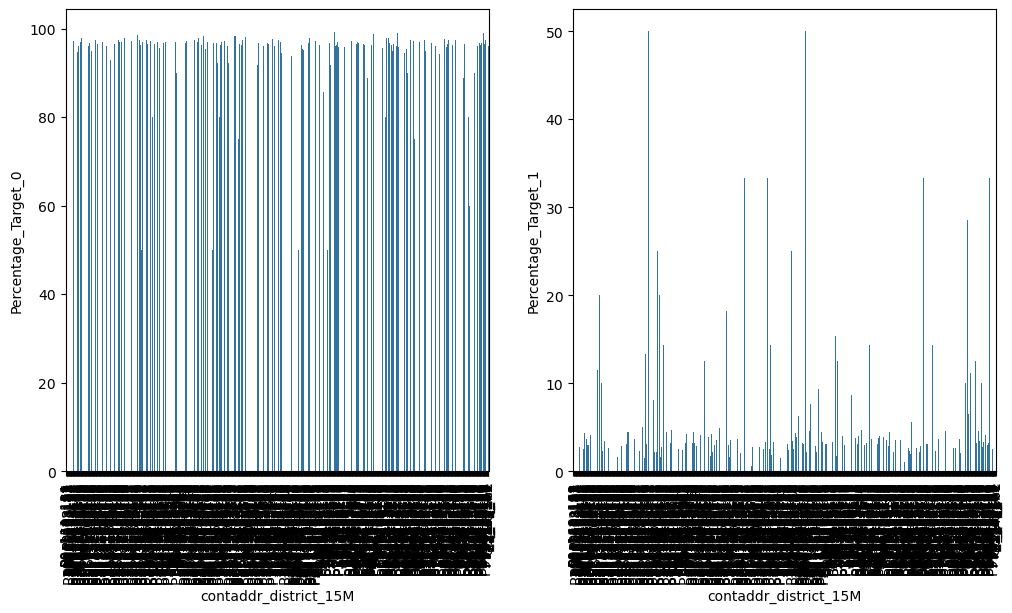

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_perc_0 = df[df['target'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_perc_1 = df[df['target'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xtic

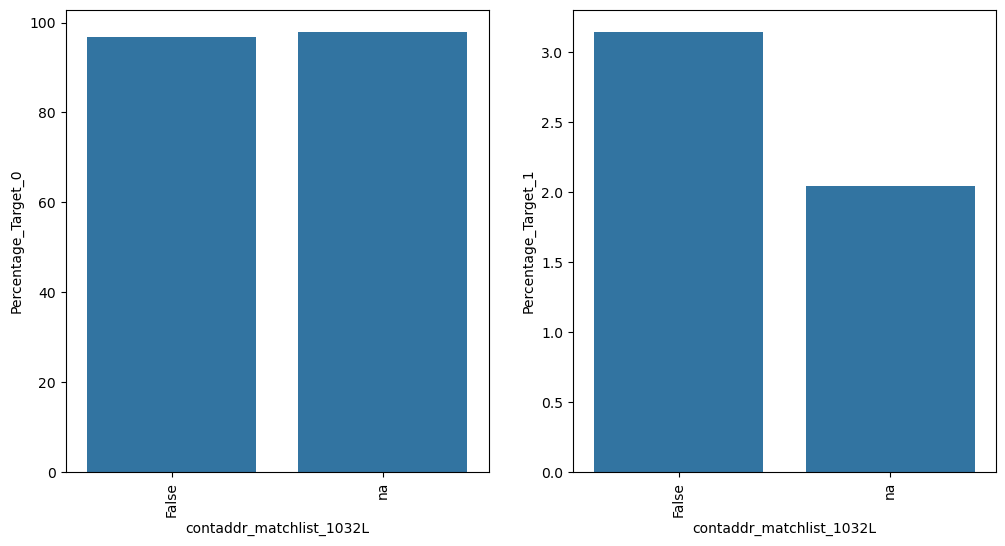

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


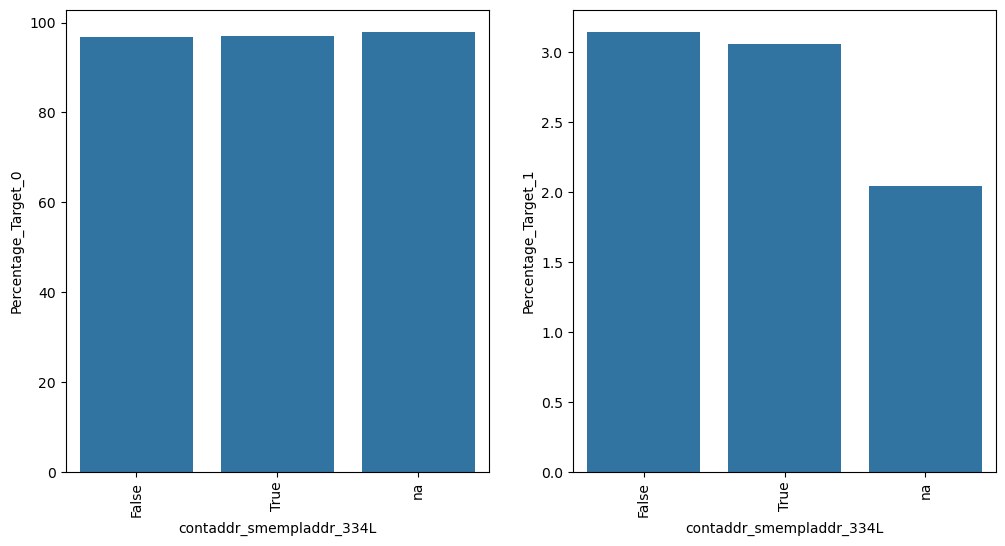

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


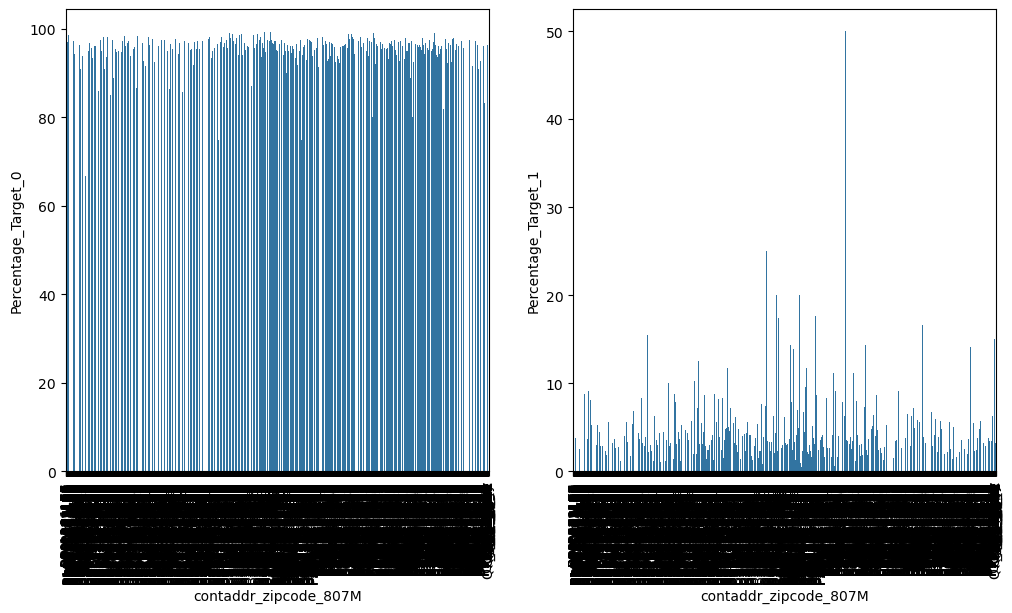

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


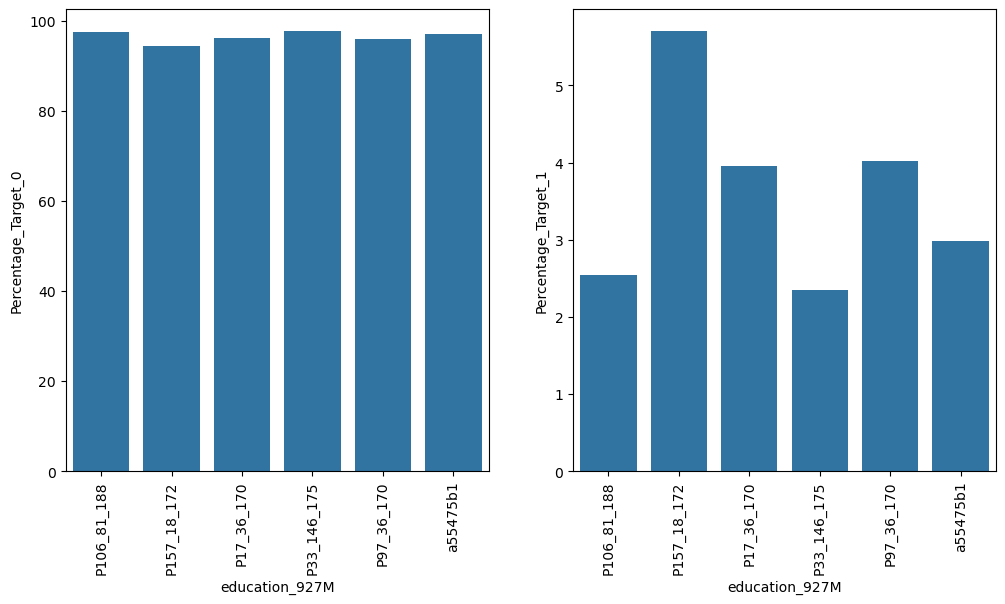

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


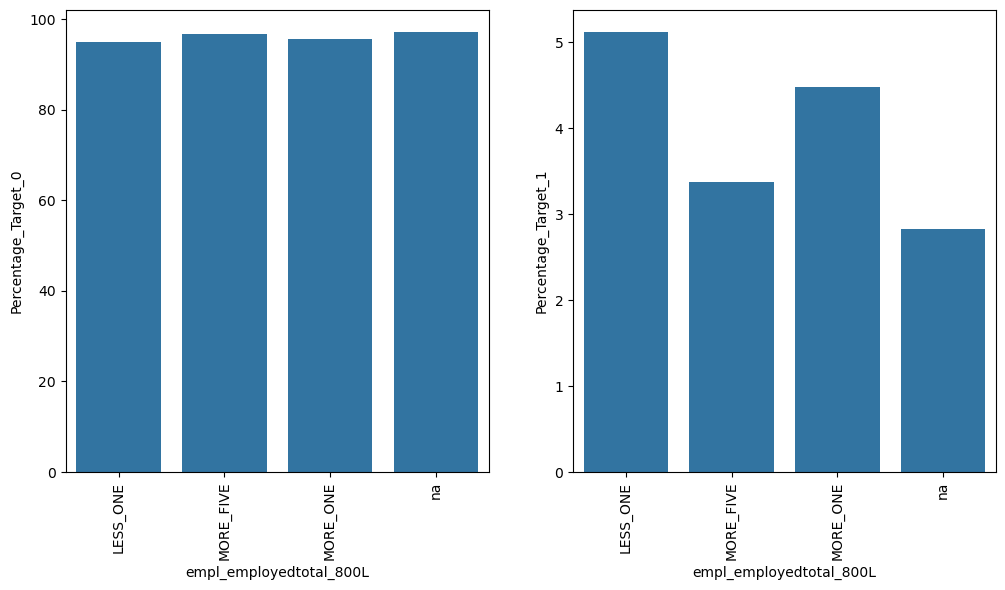

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


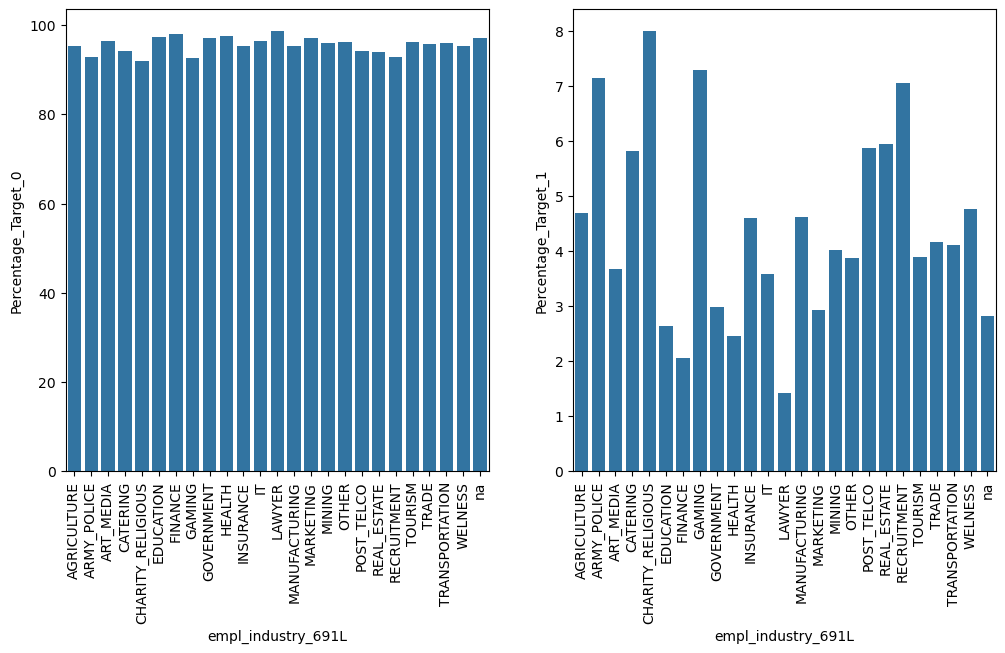

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


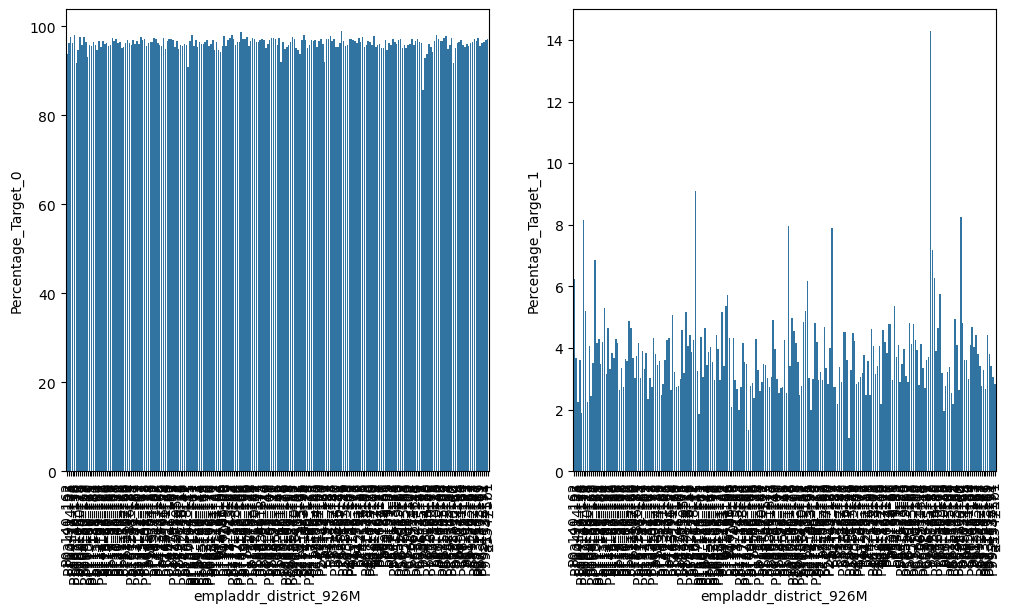

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


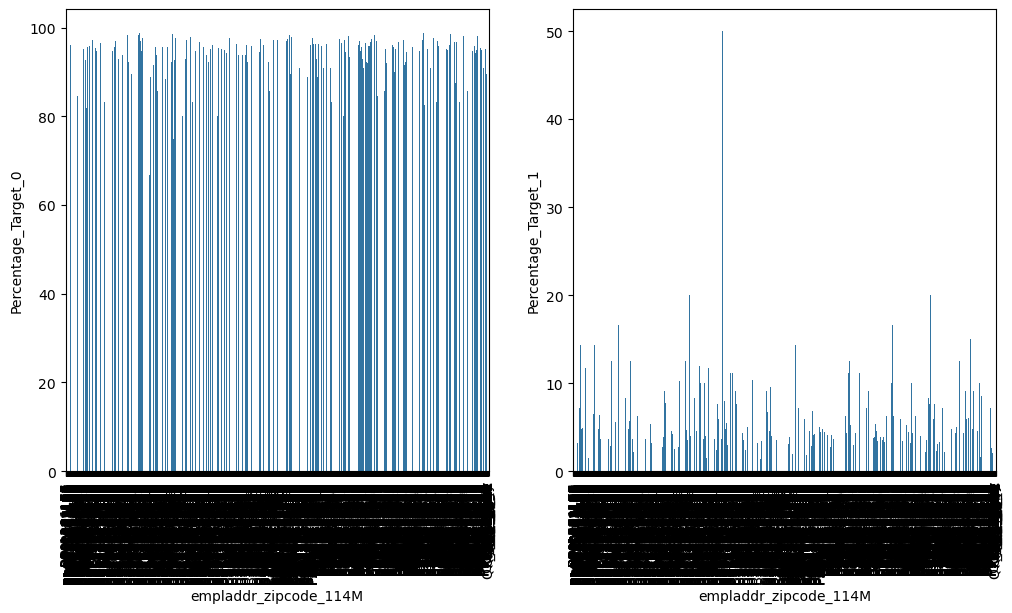

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


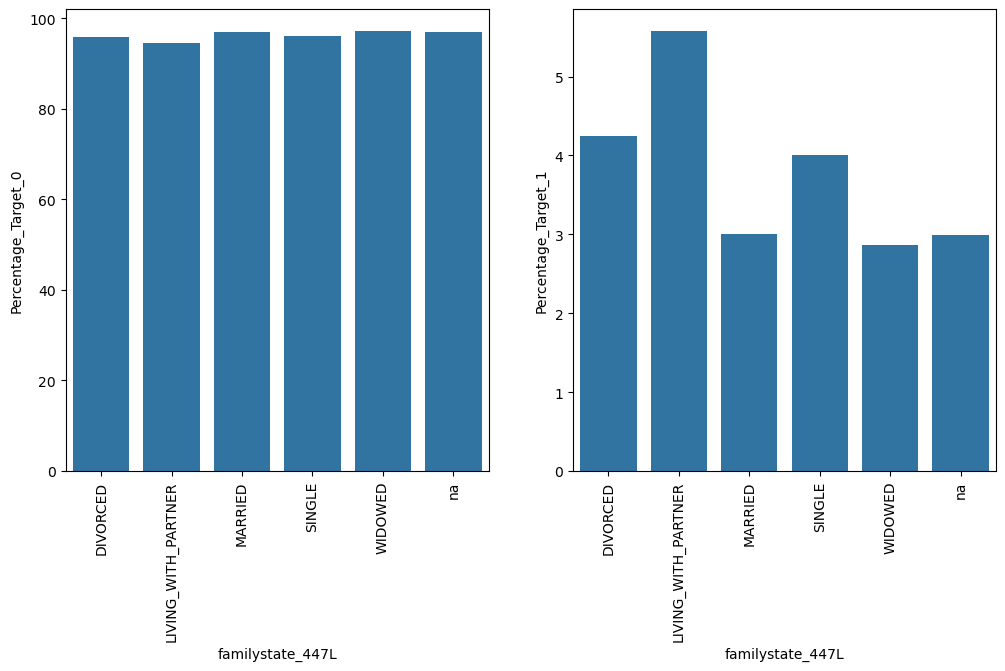

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


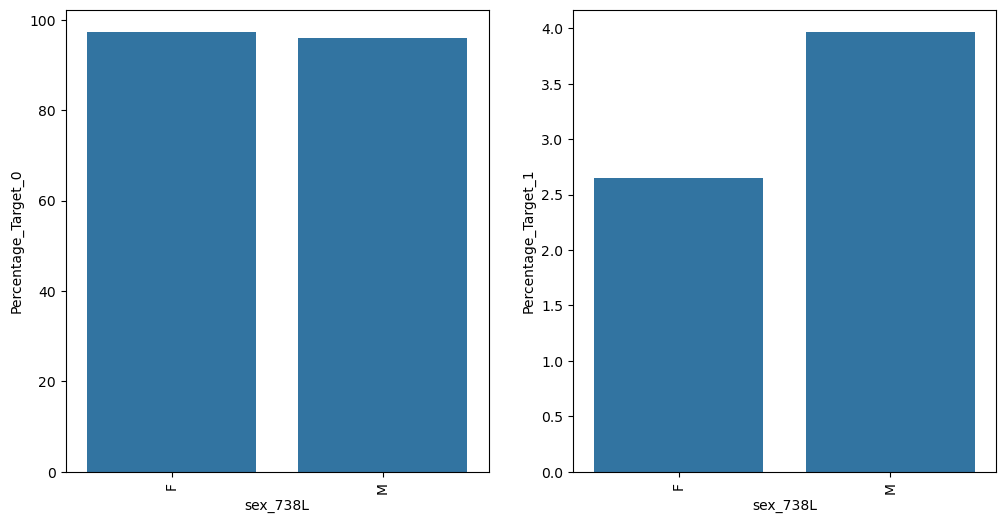

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


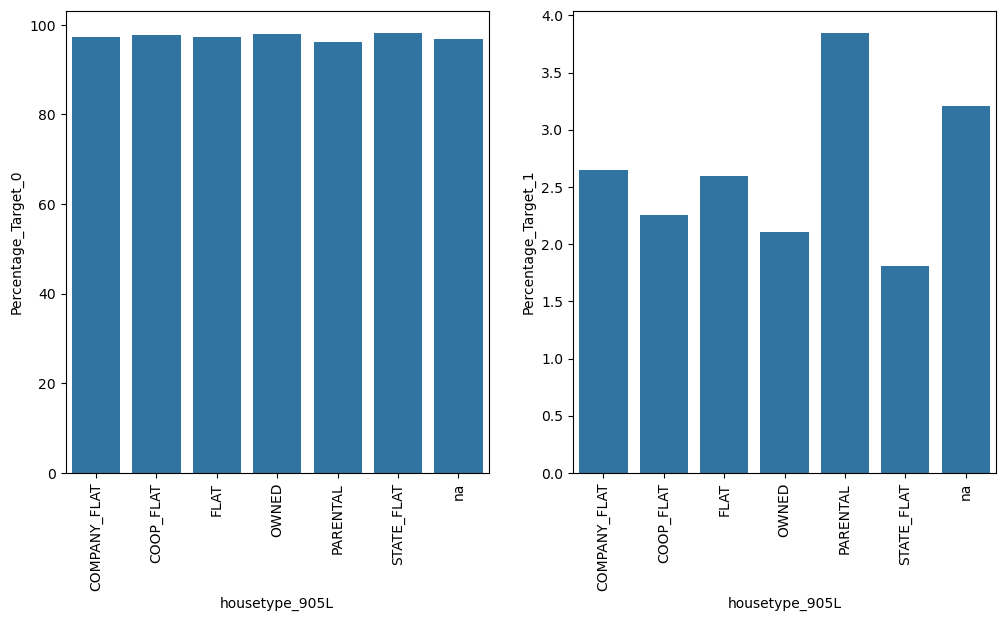

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


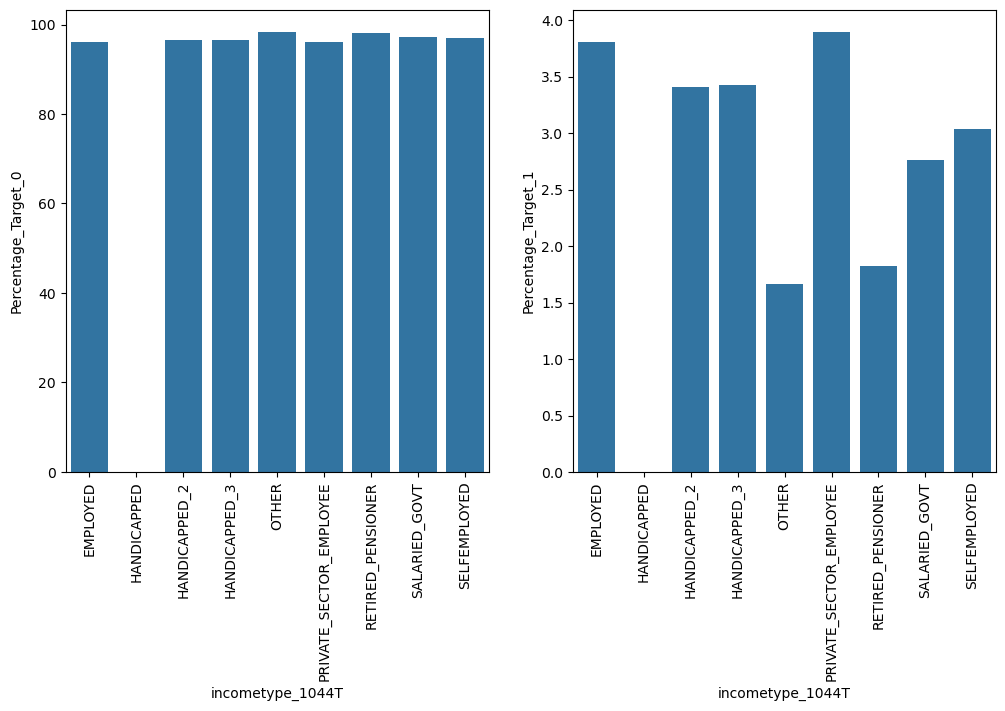

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


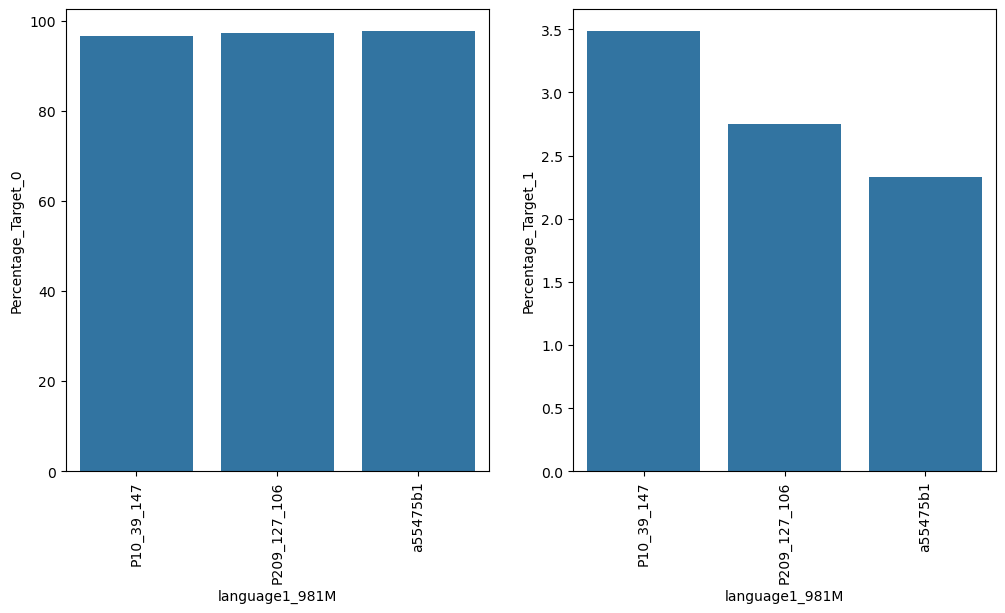

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


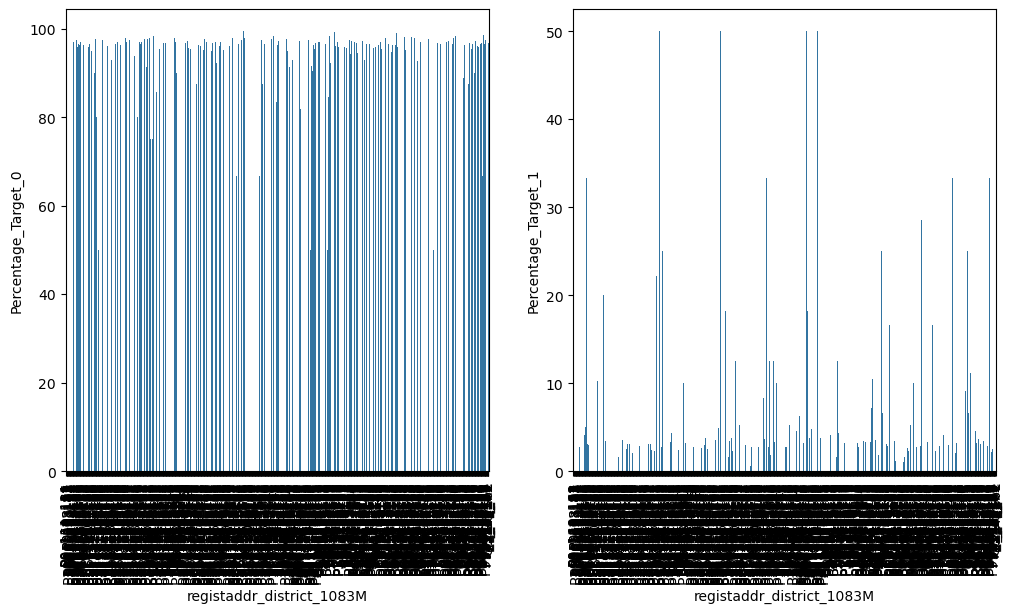

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


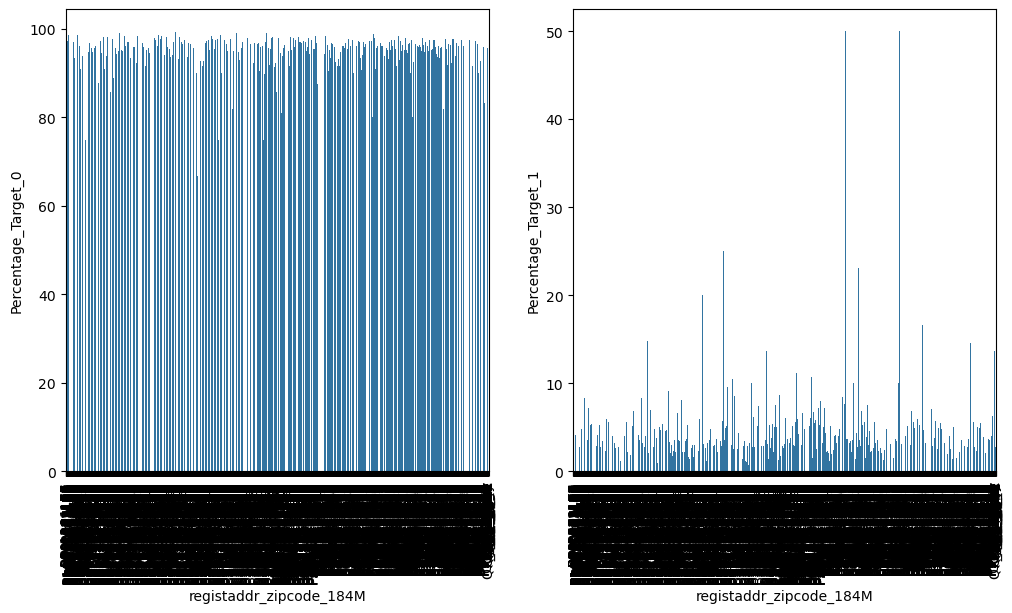

/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
/var/folders/3h/y079f1p91rx6mnr55mvdl__h0000gn/T/ipykernel_38212/2291313472.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


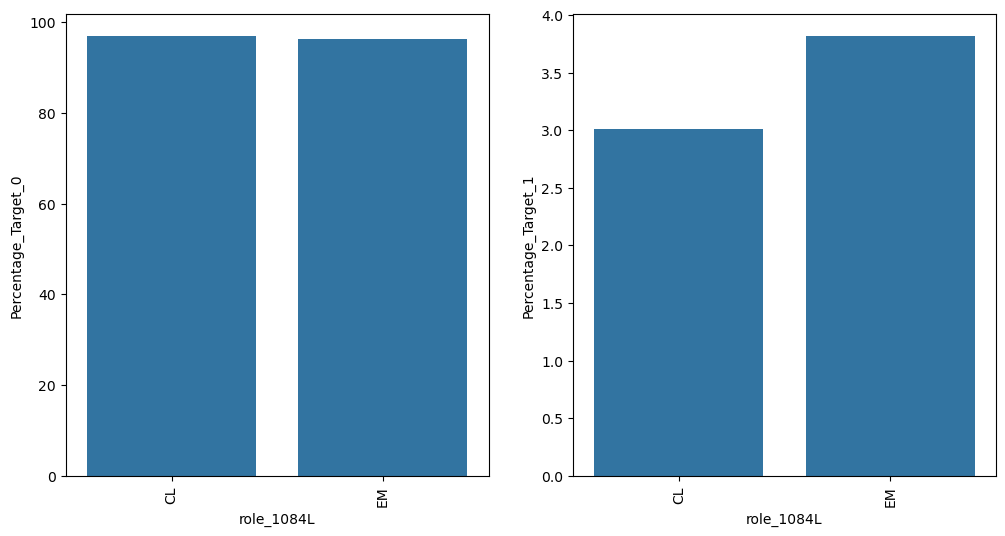

TypeError: '<' not supported between instances of 'str' and 'bool'

In [119]:
cat_stats(train_cat.drop(['case_id'],axis=1),columns_object)

`riskassesment_302T` should be converted to a numerical feature.
We shall drop the following columns with high p-values: `lastapprcommoditytypec_5251766M`,`contaddr_smempladdr_334L`, `contaddr_matchlist_1032L`, `lastrejectcommodtypec_5251769M`, `safeguarantyflag_411L`.

There are features with high degrees of freedom. We collect them into a list for further processing.

In [72]:
train_basetable['paytype1st_925L'].value_counts()

paytype1st_925L
OTHER    1468084
Name: count, dtype: int64

## Feature engineering <a class="anchor" id="feature_engine"></a>

In [158]:
#maininc_215A,mainoccupationinc_384A
for i in columns_annuity:
    train_basetable['0_ratio_'+i] = train_basetable[['maininc_215A','mainoccupationinc_384A']].max(axis=1)/(1+train_basetable[i])
#    train_basetable['0_ratio_'+i] = (train_basetable['maininc_215A']+train_basetable['mainoccupationinc_384A'])/(1+12*train_basetable[i])

In [267]:
train_basetable[['target','0_ratio_monthsannuity_845L','0_ratio_annuity_780A','0_ratio_maxannuity_159A','0_ratio_maxannuity_4075009A','0_ratio_annuitynextmonth_57A']+columns_annuity].corr()

,target,0_ratio_monthsannuity_845L,0_ratio_annuity_780A,0_ratio_maxannuity_159A,0_ratio_maxannuity_4075009A,0_ratio_annuitynextmonth_57A,monthsannuity_845L,annuity_780A,maxannuity_159A,maxannuity_4075009A,annuitynextmonth_57A
target,1.000000,0.021168,-0.006334,0.016840,0.004748,-0.009656,-0.040411,0.013838,0.013249,-0.010332,0.006378
0_ratio_monthsannuity_845L,0.021168,1.000000,0.169576,0.337561,0.133419,0.148565,-0.388573,0.026031,-0.071389,-0.009573,-0.029380
0_ratio_annuity_780A,-0.006334,0.169576,1.000000,0.042853,0.527999,0.191206,-0.043760,-0.458062,-0.006186,-0.045226,0.035595
0_ratio_maxannuity_159A,0.016840,0.337561,0.042853,1.000000,0.157207,0.270110,-0.050157,0.014286,-0.114888,-0.031787,-0.179756
0_ratio_maxannuity_4075009A,0.004748,0.133419,0.527999,0.157207,1.000000,0.075506,0.025977,-0.231212,-0.024884,-0.277005,0.045224
0_ratio_annuitynextmonth_57A,-0.009656,0.148565,0.191206,0.270110,0.075506,1.000000,-0.139551,0.161260,-0.015813,-0.000752,-0.536635
monthsannuity_845L,-0.040411,-0.388573,-0.043760,-0.050157,0.025977,-0.139551,1.000000,0.089398,0.201315,0.058205,0.274685
annuity_780A,0.013838,0.026031,-0.458062,0.014286,-0.231212,0.161260,0.089398,1.000000,0.072278,0.142319,0.101330
maxannuity_159A,0.013249,-0.071389,-0.006186,-0.114888,-0.024884,-0.015813,0.201315,0.072278,1.000000,0.057717,0.121311
maxannuity_4075009A,-0.010332,-0.009573,-0.045226,-0.031787,-0.277005,-0.000752,0.058205,0.142319,0.057717,1.000000,0.062579


In [228]:
columns_inst = correlation_matrix['target'].loc[correlation_matrix.index.str.contains('inst')].index.tolist()
#train_basetable[['target']+columns_inst].corr()
for i in columns_inst:
    train_basetable['0_square_'+i] = train_basetable[i]**2

In [229]:
train_basetable = train_basetable.drop(columns_inst, axis=1)

In [238]:
train_basetable.columns.tolist()

['case_id',
 'date_decision',
 'MONTH',
 'WEEK_NUM',
 'target',
 'contaddr_district_15M',
 'contaddr_matchlist_1032L',
 'contaddr_smempladdr_334L',
 'contaddr_zipcode_807M',
 'education_927M',
 'empl_employedtotal_800L',
 'empl_industry_691L',
 'empladdr_district_926M',
 'empladdr_zipcode_114M',
 'familystate_447L',
 'sex_738L',
 'housetype_905L',
 'incometype_1044T',
 'language1_981M',
 'mainoccupationinc_384A',
 'registaddr_district_1083M',
 'registaddr_zipcode_184M',
 'role_1084L',
 'safeguarantyflag_411L',
 'type_25L',
 'childnum_185L',
 'actualdpdtolerance_344P',
 'annuity_780A',
 'annuitynextmonth_57A',
 'applicationcnt_361L',
 'applications30d_658L',
 'applicationscnt_1086L',
 'applicationscnt_464L',
 'applicationscnt_629L',
 'applicationscnt_867L',
 'avgdbddpdlast24m_3658932P',
 'avgdbddpdlast3m_4187120P',
 'avgdbdtollast24m_4525197P',
 'avgdpdtolclosure24_3658938P',
 'avglnamtstart24m_4525187A',
 'avgmaxdpdlast9m_3716943P',
 'avgoutstandbalancel6m_4187114A',
 'avgpmtlast12m_45

In [236]:
columns_dpd=correlation_matrix['target'].loc[correlation_matrix.index.str.contains('dpd')].index.tolist()
columns_dpd 
#= columns_dpd.remove('numinstlswithdpd10_728L')
#for i in columns_dpd:
#    train_basetable['0_square_minus_'+i] = train_basetable[i]**2
#    train_basetable['0_square_minus_'+i] += - train_basetable[i]

['numinstlswithdpd10_728L',
 'avgmaxdpdlast9m_3716943P',
 'rel_apply_datelastinstal40dpd_247D',
 'numinstlswithdpd5_4187116L',
 'avgdbddpdlast24m_3658932P',
 'avgdpdtolclosure24_3658938P',
 'numinstlswithoutdpd_562L',
 'maxdpdtolerance_374P',
 'maxdbddpdtollast12m_3658940P',
 'mindbddpdlast24m_3658935P',
 'maxdpdfrom6mto36m_3546853P',
 'maxdpdlast24m_143P',
 'maxdbddpdtollast6m_4187119P',
 'avgdbddpdlast3m_4187120P',
 'maxdpdlast12m_727P',
 'maxdpdlast9m_1059P',
 'maxdbddpdlast1m_3658939P',
 'rel_apply_maxdpdinstldate_3546855D',
 'maxdpdlast6m_474P',
 'maxdpdlast3m_392P',
 'maxdpdinstlnum_3546846P',
 'actualdpdtolerance_344P']

In [232]:
train_basetable['numinstlswithdpd10_728L']

KeyError: 'numinstlswithdpd10_728L'

In [162]:
#maininc_215A,mainoccupationinc_384A
for i in columns_dpd:
    train_basetable['0_ratio_'+i] = train_basetable[['maininc_215A','mainoccupationinc_384A']].max(axis=1)/(1+train_basetable[i])
#    train_basetable['0_ratio_'+i] = (train_basetable['maininc_215A']+train_basetable['mainoccupationinc_384A'])/(1+12*train_basetable[i])

In [163]:
correlation_matrix['target'].loc[correlation_matrix.index.str.contains('dpd')]

numinstlswithdpd10_728L               0.090439
avgmaxdpdlast9m_3716943P              0.089878
rel_apply_datelastinstal40dpd_247D   -0.086439
numinstlswithdpd5_4187116L            0.073371
avgdbddpdlast24m_3658932P             0.054034
avgdpdtolclosure24_3658938P           0.052363
numinstlswithoutdpd_562L             -0.050399
maxdpdtolerance_374P                  0.049517
maxdbddpdtollast12m_3658940P          0.047754
mindbddpdlast24m_3658935P             0.047633
maxdpdfrom6mto36m_3546853P            0.044739
maxdpdlast24m_143P                    0.042495
maxdbddpdtollast6m_4187119P           0.042214
avgdbddpdlast3m_4187120P              0.039799
maxdpdlast12m_727P                    0.038253
maxdpdlast9m_1059P                    0.034622
maxdbddpdlast1m_3658939P              0.033370
rel_apply_maxdpdinstldate_3546855D   -0.030266
maxdpdlast6m_474P                     0.028847
maxdpdlast3m_392P                     0.019238
maxdpdinstlnum_3546846P              -0.012713
actualdpdtole

## Model training <a class="anchor" id="training"></a>

In [239]:
columns_object= train_basetable.drop(columns_base,axis=1).select_dtypes(include = ['object','bool']).columns.tolist()
train_basetable = train_basetable.drop(columns_object,axis=1)

In [ ]:
# Train, validation, test split
data_train, data_test = train_test_split(train_basetable.copy(),
                                            shuffle=True,
                                            random_state=338,
                                            train_size = 0.6,
                                            stratify=train_basetable['target'])

data_valid, data_test = train_test_split(data_test.copy(),
                                            shuffle=True,
                                            random_state=338,
                                            train_size = 0.5,
                                            stratify=data_test['target'])

In [180]:
float_mean = data_train.drop(columns_base,axis=1)[columns_float].mean().to_dict()

data_valid[columns_float]=data_valid[columns_float].fillna(data_train[columns_float].mean())

data_test[columns_float]=data_test[columns_float].fillna(data_train[columns_float].mean())

data_train[columns_float]=data_train[columns_float].fillna(data_train[columns_float].mean())

In [181]:
data_train[columns_int]=data_train[columns_int].fillna(0)
data_valid[columns_int]=data_valid[columns_int].fillna(0)
data_test[columns_int]=data_test[columns_int].fillna(0)

In [182]:
X_train = data_train.drop(columns = columns_base)
y_train = data_train.target

X_valid = data_valid.drop(columns = columns_base)
y_valid = data_valid.target

X_test = data_test.drop(columns = columns_base)
y_test = data_test.target

In [183]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train[columns_float] = scaler.fit_transform(X_train[columns_float])
X_valid[columns_float] = scaler.fit_transform(X_valid[columns_float])
X_test[columns_float] = scaler.fit_transform(X_test[columns_float])

In [184]:
#Original AUC: 0.7786
# Define the neural network architecture
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

# Specify the learning rate of the Adam optimizer
adam_optimizer = Adam(learning_rate=0.001)

# Compile the model with AUC as the metric
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=50)

# Check unique values in y_train
unique_classes = np.unique(y_train)
print(f"Unique classes in y_train: {unique_classes}")

# Ensure y_train is a numpy array
y_train = np.array(y_train)

# Define class weights to address class imbalance
class_weights = {0: 30, 1: 1}  # Adjust weights based on the class distribution

# Check if the class weights match the unique classes
if not all(key in unique_classes for key in class_weights.keys()):
    raise ValueError(f"Class weights keys {class_weights.keys()} do not match the unique classes {unique_classes} in y_train")

# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data=(X_valid, y_valid), callbacks=[early_stopping], class_weight=class_weights)

# Predict probabilities for the test set
y_pred_proba = model.predict(X_test)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f'Test AUC: {auc_score:.4f}')

/Users/kwongszehong/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Unique classes in y_train: [0 1]
Epoch 1/300
28625/28625 ━━━━━━━━━━━━━━━━━━━━ 15s 503us/step - auc_3: 0.5000 - loss: nan - val_auc_3: 0.5000 - val_loss: nan
Epoch 2/300
14544/28625 ━━━━━━━━━━━━━━━━━━━━ 5s 400us/step - auc_3: 0.5000 - loss: nan

KeyboardInterrupt: 

## Feature importance analysis <a class="anchor" id="shap"></a>

In [132]:
print('It\'s really hot.')

It's really hot.


In [140]:
def process_text(text):
    new_text = ""
    for char in text:
        if char.isalpha():
            new_text += char.upper()
    print(f"Processed Text: {new_text}")

process_text("Happy Coding, F1iends!")

Processed Text: HAPPYCODINGFIENDS


In [152]:
astronauts_data = "Buzz Aldrin, 1930;Yuri Gagarin, 1934;Valentina Tereshkova, 1937"

# Splitting the string into a list of astronaut info and stripping any whitespace
astronauts_list = astronauts_data.split(";")
cleaned_astronauts = []

for astronaut in astronauts_list:
    name, year = astronaut.split(", ")
    print(name)
    print(year)
    print(astronaut.split(', '))

Buzz Aldrin
1930
['Buzz Aldrin', '1930']
Yuri Gagarin
1934
['Yuri Gagarin', '1934']
Valentina Tereshkova
1937
['Valentina Tereshkova', '1937']


In [216]:
employee_data = "Name: John Doe, Age: 30, Role: Engineer"

employee_info = employee_data.split(',')

# Use strip to clean data and join to create a string with newlines
cleaned_data = "\n".join(info.strip() for info in employee_info)
cleaned_data

'Name: John Doe\nAge: 30\nRole: Engineer'

In [225]:
def find_anagram_words(list_1, list_2):
    # implement this
    sort_1 = set(sorted(word) for word in list_1)
    sort_2 = set(sorted(word) for word in list_2)
    sort_common = sort_1 & sort_2
    
    pick_word = set()
    for word in list_1:
        if sorted(word) in sort_common:
            pick_word.add(word)
    
    return list(pick_word)

find_anagram_words(['cinema', 'iceman'], ['iceman', 'cinema'])
#print(find_anagram_words(['cinema', 'iceman'], ['iceman', 'cinema'])) # should return ['cinema', 'iceman']
#print(find_anagram_words(['test', 'stet'], ['tent', 'nett'])) # should return []
#print(find_anagram_words(['hello', 'world'], ['dolly', 'sir'])) # should return []

TypeError: unhashable type: 'list'

In [250]:
def get_rank(my_dict):
    return my_dict[1]
test_dict = {'A': 2, 'B': 4, 'C': 1, 'D': 16}
sorted(test_dict.items(), key= get_rank, reverse = True)

[('D', 16), ('B', 4), ('A', 2), ('C', 1)]

In [272]:
dict = {'a':1, 'b':2,'c': 3}
dict.keys()

dict_keys(['a', 'b', 'c'])

In [265]:
i,j =0, 0

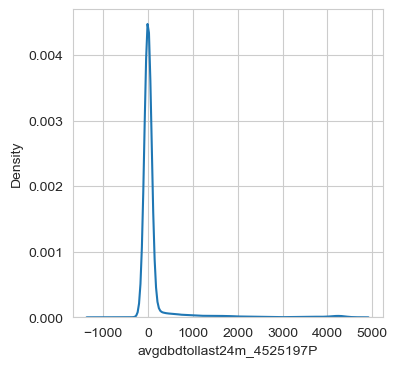

In [176]:
t0 = train_basetable.loc[train_basetable['target']==1]
sns.set_style('whitegrid')
fig,ax =plt.subplots(1,1,figsize=(4,4))

plt.subplot(1,1,1)
sns.kdeplot(t0['avgdbdtollast24m_4525197P'])
plt.show()

#avgdbdtollast24m_4525197P
#avgdpdtolclosure24_3658938P

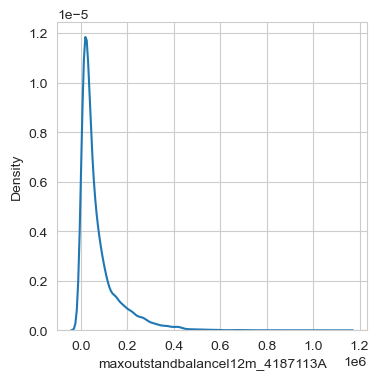

In [187]:
#avgoutstandbalancel6m_4187114A
#maxoutstandbalancel12m_4187113A
t0 = train_basetable.loc[train_basetable['target']==1]
sns.set_style('whitegrid')
fig,ax =plt.subplots(1,1,figsize=(4,4))

plt.subplot(1,1,1)
sns.kdeplot(t0['maxoutstandbalancel12m_4187113A'])
plt.show()

#avgdbdtollast24m_4525197P
#avgdpdtolclosure24_3658938P

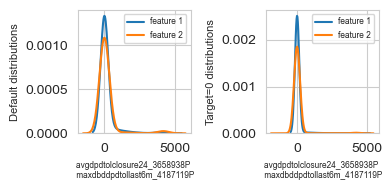

In [192]:
# last correlated features list
#avgoutstandbalancel6m_4187114A
#maxoutstandbalancel12m_4187113A
#coco_list = [['avgoutstandbalancel6m_4187114A','maxoutstandbalancel12m_4187113A']]
coco_list = [['avgdpdtolclosure24_3658938P','maxdbddpdtollast6m_4187119P']]
# plot
t1 = train_basetable.loc[train_basetable['target'] != 0]
t0 = train_basetable.loc[train_basetable['target'] == 0]

sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 2, figsize=(4,2))

for feature_list in coco_list:
    plt.subplot(1, 2, 1)
    #plt.title(f"{feature_list[0]} \n {feature_list[1]}", fontsize = 8)
    plt.ylabel('Default distributions', fontsize=8)
    plt.xlabel(f"{feature_list[0]} \n {feature_list[1]}", fontsize = 6)
    j = 0
    for feature in feature_list:
        j += 1
        sns.kdeplot(t1[feature], bw_method=0.5, label = 'feature %i' %j)
    plt.legend(loc='upper right', fontsize = "6")

    plt.subplot(1, 2, 2)
    #plt.title(f"{feature_list[0]} \n {feature_list[1]}", fontsize = 8)
    plt.ylabel('Target=0 distributions', fontsize=8)
    plt.xlabel(f"{feature_list[0]} \n {feature_list[1]}", fontsize = 6)
    j = 0
    for feature in feature_list:
        j += 1
        sns.kdeplot(t0[feature], bw_method=0.5, label = 'feature %i' %j)
    plt.legend(loc='upper right', fontsize = "6")

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()